In [1]:
# This code is an implementation of the model proposed by Foster Dayan and Morris (Hippocampus, 2000). 
# This is the DMP algrithm in which every day the location of the platform changes and every trial the 
# start location of the rat changes. We can define the number of rats (= number of independant experiment 
# to perform statistics), the number of days and the number of trials per day. 
# This particular code is the implementation of their second model in which they store an estimate of 
# the positions to perform better. 

In [2]:
using Polynomials

In [3]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE CLASSES           ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [4]:
type Trial
    Trajectory
    Latency
    SearchPreference
    ActionMap
    Valuemap
    Error
    xweight
    yweight
    platformestimate
    
end

In [5]:
type Day 
    trial::Any
    Day()=new(Trial[]);
    Platform::Any
end

In [6]:
type Experiment 
    day::Any
        Experiment()=new(Day[])

    PlaceCells::Any
end

In [7]:
type Rat
    experiment::Any
    Rat()=new(Experiment[])
    parameters
    featuresexperiment
end

In [8]:
###################################################################################
###################################################################################
########################                                ###########################
########################       DEFINE FUNCTIONS         ###########################
########################                                ###########################
########################                                ##########################
########################                                ##########################
###################################################################################
###################################################################################


In [9]:
#The algorithm places n points, of which the kth point is put at distance sqrt(k-1/2) from the boundary (index begins with k=1), and with polar angle 2*pi*k/phi^2 where phi is the golden ratio. Exception: the last alpha*sqrt(n) points are placed on the outer boundary of the circle, and the polar radius of other points is scaled to account for that. This computation of the polar radius is done in the function radius.

function  radius(k,n,b) # k index of point on the boundary, n number of total points, b number of boundary points
    if k>n-b
        r = 1;            # put on the boundary
    else
        r = sqrt(k-1/2)/sqrt(n-(b+1)/2);     # computation of radius of the different points 
    end
end



radius (generic function with 1 method)

In [10]:
# sunflower seed arrangement :
function sunflower(n, R, alpha)   # n number of centers,
    # alpha is indicating how much one cares about the evenness of boundary , chose 2 to have nice trade off
    # R is the radius of the circle in cm
    r=Array{Any}( n);
    theta=Array{Any}( n);
    b = round(alpha*sqrt(n));      # number of boundary points
    phi = (sqrt(5)+1)/2;           # golden ratio
    
    for k=1:n
        r[k] = R*radius(k,n,b); # computation of the radius of each point 
        theta[k] = 2*pi*k/phi^2; # computation of the angle of each point 
        
        #plot(r*cos.(theta), r*sin.(theta), "m");
    end
    # scatter(r.*cos.(theta), r.*sin.(theta));#, marker='o', "m");
    X=r.*cos.(theta); 
    Y=r.*sin.(theta);
    return hcat(X, Y)
end

Xplacecell=sunflower(493, 100, 2)[:,1];
Yplacecell=sunflower(493, 100, 2)[:,2];

In [11]:
# Define the place activity :

# Define activity as a function of position 
###### !!!!!!! POSITIONS TO BE GIVEN IN THE SAME UNITE THAN THE SIGMA ###### !!!!!!!
function place_activity(x,y,xpc,ypc,σ) # x,y 2 scalars the position of the rat, xpc,ypc 2 vectors posiions of all place cells
    N=length(xpc); # N number of place cells 
    actplacecell=zeros(N,1); # define empty array of activity 
    
    for k=1:N # k is the k-th place cell
        actplacecell[k]=exp(-((x-xpc[k])^2+(y-ypc[k])^2)/(2σ^2));
    end
    return actplacecell
end 

place_activity (generic function with 1 method)

In [12]:
function  placecells(position,centres,width)
# PLACECELLS Calculates the activity of the place cells in the simulation.
#
#	F = PLACECELLS(POSITION,CENTRES,WIDTH) calculates the activity of the place cells
#	in the simulation. The returned vector F is of length N, where N is the number of place
#	cells, and it contains the activity of each place cell given the simulated rat's current
#	POSITION (a 2 element column vector). The activity of the place cells is modelled as a
#	rate-of-fire (i.e. a scalar value) determined by a gaussian function. The CENTRES of the
#	gaussian functions are an argument, and must be a 2 x N matrix containing each place
#	cell's preferred location in 2D space. The WIDTH of the place cell fields must
#	also be provided as a scalar value (all place cells are assumed to have the same
#	width).
#
#	The returned vector, F, must be a N element column vector.
#
#	Code for BIO/NROD08 Assignment 2, Winter 2017
#	Author: Blake Richards, blake.richards@utoronto.ca


# calculate the place cell activity
F = exp.(-sum((repmat(position,1,size(centres,2))-centres).^2,1)/(2*width^2))';
return F
end


placecells (generic function with 1 method)

In [13]:
# Calculate reward as a function of position 
function reward(x,y,xp,yp,r) # x,y position of the rat and xp,yp position of the platform, r radius of the platform
    if (x-xp)^2+(y-yp)^2<= r^2 # if the rat is in the platform
        R=1;
    else # else 
        R=0;
    end 
    
end


reward (generic function with 1 method)

In [14]:
# Function to return the cumulative sum of the terms of a vector : 
function cumul(A) # A vector 
    Acum=zeros(length(A),1);
    for k=1:length(A)
       Acum[k]=sum(A[1:k]);
    
    end
    return Acum
end

cumul (generic function with 1 method)

In [15]:
# This function tells within wich index column is located x
function indice(Acum,x) # x number, Acum vector
    j=0;
    for i=1:length(Acum)
       if i==1
           if x<Acum[i]
                    println("the index of the action chosen is")
                    # check that i is an integer 
                        if typeof(i)==Void
                            return("indeed the type if void")
                        else
                            println("the type is not void")
                        end
                j=i;

            end
        else
            if Acum[i-1]<x<=Acum[i]
                println("the index of the action chosen is")
                if typeof(i)==Void
                    return("indeed the type if void")
                else
                    println("the type is not void")
                end
               j=i;
            end
        end
    end  
    
    if j==0
        println("je ne comprends pas ce quil se passe")
    else
    return Int[j]
    end
end

indice (generic function with 1 method)

In [16]:
###################################################################################
################## GENERAL THINGS THAT DONT CHANGE WITHIN TRIALS ##################
###################################################################################

# Creating the circle and the place cells:
center=[0,0];
R= 100; # Radius of the circle in cm
r=5;# Radius of the platform  in cm
radiussearchpref=20; # radius of the area in which we calculate searchpreference 

# Motion characteristic 
dt=0.1; # timestep in s 
speed=30; # speed of the rat in cm.s-1
# Different possible directions 
angles=[-3*pi/4, -2*pi/4, -pi/4, 0, pi/4, 2*pi/4, 3*pi/4, pi];


# Trial characteristic :
T=120; # maximal duration of a trial in seconds
DeltaT=15; # Interval between trials in seconds  

# Place cells 
N=493; # number of place cells 
Xplacecell=sunflower(N,R,2)[:,1]; # absciss place cells  
Yplacecell=sunflower(N,R,2)[:,2]; # y place cells 


# Place cell : method used by Blake richards 
# initialize the centres of the place cells by random unifrom sampling across the pool
arguments= rand(1,N)*2*pi;
radii= sqrt.(rand(1,N))*R;
centres= [cos.(arguments).*radii; sin.(arguments).*radii]; 
Xplacecell=centres[1,:];
Yplacecell=centres[2,:];

σ=0.30*100; # variability of place cell activity, in centimeters


# Action cells : 
n=9; # number of action cells 


# Potential positions of the platform : 
Xplatform=[0.3,0,-0.3,0,0.5,-0.5,0.5,-0.5].*R; # in cm
Yplatform=[0,0.3,0,-0.3,0.5,0.5,-0.5,-0.5].*R;# in cm

# Potential Starting positions of the rat :
Xstart=[0.95,0,-0.95,0].*R; # East, North, West, South
Ystart=[0,0.95,0,-0.95].*R;

# Define number of rats, number of days and numbers of trials per day
numberofdays=10;
numberofrats=3;
numberoftrials=4;


times=collect(0:dt:T+dt);

In [38]:

# Parameter that regulate the choice between former angle and new angle 
momentum=1.0;



# Learning variables : 
γ=0.98; # Discount factor.  they dont precise the value  
Z=0.1; # actor learning rate
W=0.01; # critic learning rate

# learning rate for position:
Wx=0.001; # learning rate for x coordinate 
Wy=0.001;  # learning rate for y coordinate 

# parameter for postion estimation 
λ=0.8;

In [37]:
#########################################################################
#############          LOOP       1   EXPERIMENT FOR 1 DAY 1 RAT   ######################
#########################################################################



@time begin # get the time it takes to run it 

rats=Rat();
rats.parameters=[momentum,γ,Z,W]; # Save different parameters 
rats.featuresexperiment=[numberofrats, numberofdays, numberoftrials];

    
println("start of experiments")

for indexrat=1:numberofrats
    
currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 

# Initialisation variables :
w=zeros(N,1); # weight for critic
z=zeros(N,n); # weight for action cells 
wx=zeros(N,1); # weights for x coordinate estimate 
wy=zeros(N,1); # weights for y coordinate estimate           
        
        ##########  ##########  ##########  ##########   ########## 
    ##########  ##########  START EXPERIMENT  ##########  ##########  
        ##########  ##########  ##########  ##########   ########## 

# currentexperiment=Experiment(); # Creating the experiment 
#currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
    
    for indexday=1:numberofdays
        # Everyday the location of the platform changes
        # Chose platform :
        indexplatform=rand(1:8) # generate random number
        xp=Xplatform[indexplatform]; # consider chosen platform
        yp=Yplatform[indexplatform];
        
        currentday=Day(); # creating a day 
        currentday.Platform=hcat(xp,yp);  
        
        platform=0; # indicator for the acoordinate action. evry day we suppose that the rat does not know where is the platform 
        
            ##########  ##########  ##########  ##########  
        ##########  ##########  START DAY ##########  ##########  
            ##########  ##########  ##########  ##########  
           
        println("start of days")
        
        for indextrial=1:numberoftrials ##########  
            
            ## Chose starting position :
                    # Chose starting position :
              
            # just to try if it learns better
        
            indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            
            positionstart=[Xstart[indexstart] Ystart[indexstart]];
 
            position=positionstart;
            
            # Initialize reward 
            re=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            # initialise time 
            t=times[k];
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
            timeout=0;        
            prevdir=[0 0];    
            ##########  ##########  ##########  ##########   ########## 
            ##########  ##########  START TRIAL ##########  ##########  
            ##########  ##########  ##########  ##########   ########## 
            Xplatformestimate=0;
            Yplatformestimate=0;

println("start of trial")
                while t<=T && re==0
                        
                    println("rat $(indexrat), day $(indexday) trial $(indextrial), step $(k)")
                        
                        if t==T
                        println("t==T")
                            X=xp;
                            Y=yp;
                            position=[X Y];
                            println(position)
                            timeout=1; # if we have to put the rat on the platform then we dont reinforce the actor but only the critic
                            platform=1;
                            println(platform)
                        
                            Xplatformestimate=dot(wx,placecells([X,Y],centres,σ)); # we register our estimate of the position of the paltform
                            Yplatformestimate=dot(wy,placecells([X,Y],centres,σ));
                            #println("platform $(platform)", Xplatformestimate ; Yplatformestimate)
                            println(platform)
                        end
                        
                        
                        println(Xplatformestimate)
                        
                    # Store former position to be able to draw trajectory
                    push!(historyX,position[1]) 
                    push!(historyY,position[2])
                    
                    
                         ###  Compute reward ### 
                    re=reward(position[1],position[2],xp,yp,r); 
                    
                         # compute new activity of pace cells :
                    # actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ); # this function is wrong 
                    if !(k==1)
                        formeractplacecell=actplacecell; # need storing to compute the self motion estimate
                    end
                    
                    actplacecell=placecells([position[1],position[2]],centres,σ);
                
                    ### Compute Critic ###
                    C=dot(w,actplacecell); # current estimation of the future discounted reward 
                    
                    # estimate position 
                    Xestimate=dot(wx,actplacecell);
                    Yestimate=dot(wy,actplacecell);
                    positionestimate=[Xestimate Yestimate];

                    ####### Take decision and move to new position : ########
                    # Compute the activity of action cells 
    
                    #  Compute action cell activity    
                    actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
                        if maximum(actactioncell)>=100
                            actactioncell=100.*actactioncell./maximum(actactioncell); 
                        end
                    println("actactioncell  $(actactioncell)")
                    
                    # Compute probability distribution : 
                    Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                    println("Pactioncell  $(Pactioncell)")
                        
                    # Compute summed probability distribution:
                    #SumPactioncell=cumul(Pactioncell);
                    SumPactioncell=[sum(Pactioncell[1:k]) for k=1:length(Pactioncell)]
                    
                    println(typeof(SumPactioncell))
                    println("SumPactioncell", SumPactioncell)

                    
                    # Generate uniform number between 0 and 1 :
                    x=rand(1);
                    x=x[1];
                    println("random number : $(x)")
                    
                    
                    # now chose action: 
                    #indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                    #indexaction=indexaction[1]
                    
                    indexaction=0;
                    for i=1:length(SumPactioncell)
                       if (i==1)&&(x<=SumPactioncell[1])
                        
                            indexaction=i;
                        elseif !(i==1)&&(SumPactioncell[i-1]<x<=SumPactioncell[i])
                            indexaction=i;
                      
                        end
                    end  
                    
                    println("indexaction",indexaction)
                    println(typeof(indexaction))
                    
                    
                    if indexaction==9 # if we chose the acoord action
                            if platform==0 # if we havent registered the platform position yet 
                                indexaction=rand(1:8)
                                indexaction=indexaction[1]
                                argdecision=angles[Int(indexaction)]; # compute the coreesponding angle 
                                newdir=[cos(argdecision) sin(argdecision)];
                                dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
    
                            elseif platform==1 # if we have registered the platform position

                                dir=[Xplatformestimate Yplatformestimate].-positionestimate; # get the vector of displacement 
                                dir=dir./norm(dir); # normalise

                            end
                        
                        
                        else # if indexaction is one of the 8th first indexes
                        
                        println(" we took action $(indexaction)")
                        println("sumpaction cell : $(SumPactioncell)")
                        
                        argdecision=angles[Int(indexaction)]; # compute the coreesponding angle 
                        println(argdecision)
                        newdir=[cos(argdecision) sin(argdecision)];
                        dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));

                        
                    end    
                        
                        prevdir=dir;
                        # arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                        # arg=argdecision; # not good because angles too sharp
                        # Store former position 
                        formerposition=position;
                        # Compute new position : 
                        position=position.+dt.*speed.*dir; 
                        
                        X=position[1];
                        Y=position[2];
                        Xf=formerposition[1];
                        Yf=formerposition[2];
                
                    # We code walls as reflectors :
                        if X^2+Y^2>R^2 # if we are out of the circle 
                            # find the position between former position and current position that is exactly on the circle :
                            # Create Polynomial with a parameter lambda that represent the absciss along the segment
                            # search the value of lambda for which we are crossing the circle    
                            polynom=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                            # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                            β=roots(polynom)[find(x -> 0<x <1,roots(polynom))];
                            β=maximum(β); # to convert from array of float to float 
                            Xlambda=β*X+(1-β)Xf; # position of the point that is on the circle 
                            Ylambda=β*Y+(1-β)Yf;
                            delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                                
                            #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                            #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                            # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                            poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);
            
                            # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                            deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                            
                                
                            # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                            Xnew=X-deplacement*Xlambda/R;
                            Ynew=Y-deplacement*Ylambda/R;
                            #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                            #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                                if Xnew^2+Ynew^2>R^2 # if we are still out of the circle 
                                    println("we are still out")
                                    break
                                end

                            X=Xnew;
                            Y=Ynew;
                            position=[X Y];    
                        end
                    
                    # If we are now at the very edge of the maze, move us in a little bit :
                        if X^2+Y^2==R^2
                            position = (position./(X^2+Y^2))*(R - 1);
                        end
                
                    # compute new activity of pace cells :
                    actplacecell=placecells([position[1],position[2]],centres,σ);

                        if re==1 # if we are on the platform 
                           ###  Compute error ###
                            Cnext=0;
                            platform=1;
                            Xplatformestimate=dot(wx,actplacecell); # we register our estimate of the position of the paltform
                            Yplatformestimate=dot(wy,actplacecell);
                                println("re=$(re)","platform$(platform)", Xplatformestimate)

                        else 
                            Cnext=dot(w,actplacecell);# new estimation of the future discounted reward 
                        end 
                    
                
                    #### Compute error  ####
                    err=re+γ*Cnext-C;
            
                    # save error
                    push!(error,err);
                
                
                    ######### Compute new weights : ########
                        if timeout==0
                            G=zeros(n,1);
                        
                            G[indexaction]=1;
                        println("G : $(G)")
                            # weights between action cells and place cells only reinforced when the rats actually found the platform
                            # z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                            z=z+Z.*err.*actplacecell*transpose(G); 
                            println("norm z is $(norm(z))")
                        println("we updated z of  $(Z.*err.*actplacecell*transpose(G))")
                        end
                    
                    # weights between critic and place cells :
                    # Save value to draw valuemap
                    # push!(valuemap,w);
                    w=w+W.*err.*actplacecell;
    
                     ####### ####### ####### Updating search preference  ####### ####### #######
                        if (X-xp)^2+(Y-yp)^2<= radiussearchpref^2          
                            searchpref=searchpref+1*dt;
                        end
                   
                    k=k+1;
                    t=times[k];
                      
                    
                    # uopdate the weight for position estimate 
                    
                    if !(k==2)
                         # self motion estimate : 
                    deltax=dot(wx,actplacecell)-dot(wx,formeractplacecell); # how much the former weights estimate my motion
                    deltay=dot(wy,actplacecell)-dot(wy,formeractplacecell);
                     wx=wx+Wx.*(dir[1]-deltax).*(sum([λ^(k-l).*placecells([historyX[l],historyY[l]],centres,σ) for l=1:(k-1)])+actplacecell);
                    wy=wy+Wy.*(dir[2]-deltay).*(sum([λ^(k-l).*placecells([historyX[l],historyY[l]],centres,σ) for l=1:(k-1)])+actplacecell);
                    end
                #   
                #   println("norm weight x", norm(wx))
                #    println("norm weight y", norm(wy))
                #  println("max weight x", maximum(wx))
                #    println("max weight y", maximum(wy))
                #      println("min weight x", minimum(wx))
                #    println("min weight y", minimum(wy))
                ##################################################            
                end

                ########## ##########  END TRIAL ########## ##########             
            push!(historyX,position[1]) # Store the last position visited 
            push!(historyY,position[2])
            # push!(valuemap,w)
        
            ############### SAVING THE THINGS IN THE DIFFERENT CLASS ################
            ## in creating a new trial type one should write Trial(Trajectory, latency, searchpreference, actionmap) # action map atm is just z, then it will be improved adding a new attribute being value map 

            currenttrial=Trial(hcat(historyX,historyY),t,searchpref,z,w,error,wx,wy,[Xplatformestimate, Yplatformestimate]); # Creating the current trial with all its fields
      
            push!(currentday.trial,currenttrial) # Storing it in the current day 
        
                
        ##################################################     
        end 
        ########## ##########  END DAY ########## ##########
        
        
        push!(currentexperiment.day,currentday) # Storing the current day in the current experiment 
        
            
    ##################################################     
    end 
    ########## ##########  END EXPERIMENT ########## ##########

push!(rats.experiment,currentexperiment) # Storing the current experiment in the rat's class

##################################################     
end 
########## ##########  END RATS ########## ###

        
    
end # end time 

LoadError: [91msyntax: incomplete: "begin" at In[37]:5 requires end[39m

In [ ]:
#########################################################################
#############          LOOP       1   EXPERIMENT FOR 1 DAY 1 RAT   ######################
#########################################################################


rats=Rat();
rats.parameters=[momentum,γ,Z,W]; # Save different parameters 
rats.featuresexperiment=[numberofrats, numberofdays, numberoftrials];

        # Everyday the location of the platform changes
        # Chose platform :
        indexplatform=rand(1:8) # generate random number
        xp=Xplatform[indexplatform]; # consider chosen platform
        yp=Yplatform[indexplatform];
        
        currentday=Day(); # creating a day 
        currentday.Platform=hcat(xp,yp);  
        
        platform=0; # indicator for the acoordinate action. evry day we suppose that the rat does not know where is the platform 
   xhistory=[];   
currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 

# Initialisation variables :
w=zeros(N,1); # weight for critic
z=zeros(N,n); # weight for action cells 
wx=zeros(N,1); # weights for x coordinate estimate 
wy=zeros(N,1); # weights for y coordinate estimate           

 indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
 
 positionstart=[Xstart[indexstart] Ystart[indexstart]];

 position=positionstart;
 
 # Initialize reward 
 re=0;
 
 # Initialise index to save the trajectory and the values 
 k=1;
 # initialise time 
 t=times[k];
 historyX=Float64[];
 historyY=Float64[];
 #valuemap=Float64[];
 error=Float64[];
 searchpref=0;
 arg=0;        
 timeout=0;        
 prevdir=[0 0];    
 ##########  ##########  ##########  ##########   ########## 
 ##########  ##########  START TRIAL ##########  ##########  
 ##########  ##########  ##########  ##########   ########## 
 Xplatformestimate=0;
 Yplatformestimate=0;             
    err=0


historyX=[]
historyY=[]
position=[]
indexaction=0;



platform=[]
formeractplacecell=[]
Xestimate=0
Yestimate=0
positionestimate=[]
actactioncell=[]
Pactioncell=[]
SumPactioncell=[]
x=0
xhistory=[]
indexaction=0
argdecision=0
newdir=[]
dir=[]
prevdir=[]
formerposition=[]
actplacecell=[]
Cnext=0
deltax=0
 deltay=0
indexrat=0
indexday=0
indextrial=0

currenttrial=[]
dirtaken=zeros(1,2)


println("start of experiments")

for indexrat=1:numberofrats
 currentexperiment=Experiment(); # Creating the experiment 
currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
# Initialisation variables :
w=zeros(N,1); # weight for critic
z=zeros(N,n); # weight for action cells 
wx=zeros(N,1); # weights for x coordinate estimate 
wy=zeros(N,1); # weights for y coordinate estimate           
historyw=zeros(N,1)
historywx=zeros(N,1)
historywy=zeros(N,1)
        ##########  ##########  ##########  ##########   ########## 
    ##########  ##########  START EXPERIMENT  ##########  ##########  
        ##########  ##########  ##########  ##########   ########## 

# currentexperiment=Experiment(); # Creating the experiment 
#currentexperiment.PlaceCells=hcat(Xplacecell,Yplacecell); # Store location of place cells 
    
    for indexday=1:numberofdays
     # Everyday the location of the platform changes
        # Chose platform :
        indexplatform=rand(1:8) # generate random number
        xp=Xplatform[indexplatform]; # consider chosen platform
        yp=Yplatform[indexplatform];
        
        currentday=Day(); # creating a day 
        currentday.Platform=hcat(xp,yp);  
                    ##########  ##########  ##########  ##########   ########## 
            ##########  ##########  START TRIAL ##########  ##########  
            ##########  ##########  ##########  ##########   ########## 
            Xplatformestimate=0;
            Yplatformestimate=0;      
        
        platform=0; # indicator for the acoordinate action. evry day we suppose that the rat does not know where is the platform 
      
            ##########  ##########  ##########  ##########  
        ##########  ##########  START DAY ##########  ##########  
            ##########  ##########  ##########  ##########  
           
        println("start of days")
        
        for indextrial=1:numberoftrials ##########  
            
            ## Chose starting position :
                    # Chose starting position :
              
            # just to try if it learns better
         indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            
            positionstart=[Xstart[indexstart] Ystart[indexstart]];
 
            position=positionstart;
            
            # Initialize reward 
            re=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            # initialise time 
            t=times[k];
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
            timeout=0;        
            prevdir=[0 0];    
       
    err=0

historyX=[]
historyY=[]
xhistory=[];
indexaction=0;

#println("start of trial")
                while t<=T && re==0
                        
                    println("rat $(indexrat), day $(indexday) trial $(indextrial), step $(k)")
                        
                        if t==T
                        #println("t==T")
                            X=xp;
                            Y=yp;
                            position=[X Y];
                            #println(position)
                            timeout=1; # if we have to put the rat on the platform then we dont reinforce the actor but only the critic
                            platform=1;
                            #println(platform)
                        
                            Xplatformestimate=dot(wx,placecells([X,Y],centres,σ)); # we register our estimate of the position of the paltform
                            Yplatformestimate=dot(wy,placecells([X,Y],centres,σ));
                            #println("platform $(platform)", Xplatformestimate ; Yplatformestimate)
                             if Xplatformestimate>10000
                        println("ca commence a chauffer")
                        
                            end
                    if Xplatformestimate<0.001
                        println("ca commence a etre tres petit  Xplatformestimate ")
                        
                            end
                        end
                        
                        
                    
                        
                    # Store former position to be able to draw trajectory
                    push!(historyX,position[1]) 
                    push!(historyY,position[2])
                    
                    
                         ###  Compute reward ### 
                    re=reward(position[1],position[2],xp,yp,r); 
                    
                         # compute new activity of place cells :
                    # actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ); # this function is wrong 
                    if !(k==1)
                        formeractplacecell=actplacecell; # need storing to compute the self motion estimate
                    end
                    
                    actplacecell=placecells([position[1],position[2]],centres,σ);
                
                    ### Compute Critic ###
                    C=dot(w,actplacecell); # current estimation of the future discounted reward 
                    
                    # estimate position 
                    Xestimate=dot(wx,actplacecell);
                    Yestimate=dot(wy,actplacecell);
                    positionestimate=[Xestimate Yestimate];

                    ####### Take decision and move to new position : ########
                    # Compute the activity of action cells 
    
                    #  Compute action cell activity    
                    actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
                        if maximum(actactioncell)>=100
                            actactioncell=100.*actactioncell./maximum(actactioncell); 
                        end
                    
                    # Compute probability distribution : 
                    Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                        
                    # Compute summed probability distribution:
                    #SumPactioncell=cumul(Pactioncell);
                    SumPactioncell=[sum(Pactioncell[1:k]) for k=1:length(Pactioncell)]
 

                    
                    # Generate uniform number between 0 and 1 :
                    x=rand(1);
                    x=x[1];
                    push!(xhistory,x)
                    
                    
                    # now chose action: 
                    #indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                    #indexaction=indexaction[1]
                    
                    indexaction=0;
                    for i=1:length(SumPactioncell)
                       if (i==1)&&(x<=SumPactioncell[1])
                        
                            indexaction=i;
                        elseif !(i==1)&&(SumPactioncell[i-1]<x<=SumPactioncell[i])
                            indexaction=i;
                      
                        end
                    end  
 
                    if indexaction==9 # if we chose the acoord action
                            if platform==0 # if we havent registered the platform position yet 
                                indexaction=rand(1:8)
                                indexaction=indexaction[1]
                                argdecision=angles[Int(indexaction)]; # compute the coreesponding angle 
                                newdir=[cos(argdecision) sin(argdecision)];
                                dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
                                dir=dir./norm(dir);
                        
                            elseif platform==1 # if we have registered the platform position

                                dir=[Xplatformestimate Yplatformestimate].-positionestimate; # get the vector of displacement 
                                dir=dir./norm(dir); # normalise

                            end
                        
                        
                        else # if indexaction is one of the 8th first indexes
                        
    
                        
                        argdecision=angles[Int(indexaction)]; # compute the coreesponding angle 
                        #println(argdecision)
                        newdir=[cos(argdecision) sin(argdecision)];
                        dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
                        dir=dir./norm(dir);
                        
                    end    
                        
                dirtaken=hcat(dirtaken,dir)
                        prevdir=dir;
                        # arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                        # arg=argdecision; # not good because angles too sharp
                        # Store former position 
                        formerposition=position;
                        # Compute new position : 
                        position=position.+dt.*speed.*dir; 
                        
                        X=position[1];
                        Y=position[2];
                        Xf=formerposition[1];
                        Yf=formerposition[2];
                
                    # We code walls as reflectors :
                        if X^2+Y^2>R^2 # if we are out of the circle 
                            # find the position between former position and current position that is exactly on the circle :
                            # Create Polynomial with a parameter lambda that represent the absciss along the segment
                            # search the value of lambda for which we are crossing the circle    
                            polynom=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                            # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                            β=roots(polynom)[find(x -> 0<x <1,roots(polynom))];
                            β=maximum(β); # to convert from array of float to float 
                            Xlambda=β*X+(1-β)Xf; # position of the point that is on the circle 
                            Ylambda=β*Y+(1-β)Yf;
                            delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                                
                            #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                            #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                            # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                            poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);
            
                            # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                            deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                            
                                
                            # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                            Xnew=X-deplacement*Xlambda/R;
                            Ynew=Y-deplacement*Ylambda/R;
                            #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                            #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                                if Xnew^2+Ynew^2>R^2 # if we are still out of the circle 
                                    println("we are still out")
                                    break
                                end

                            X=Xnew;
                            Y=Ynew;
                            position=[X Y];    
                        end
                    
                    # If we are now at the very edge of the maze, move us in a little bit :
                        if X^2+Y^2==R^2
                            position = (position./norm(position))*(R - 1);
                        end
                
                    # compute new activity of pace cells :
                    actplacecell=placecells([position[1],position[2]],centres,σ);

                        if re==1 # if we are on the platform 
                           ###  Compute error ###
                            Cnext=0;
                            platform=1;
                            Xplatformestimate=dot(wx,actplacecell); # we register our estimate of the position of the paltform
                            Yplatformestimate=dot(wy,actplacecell);
                            #println(Xplatformestimate)
                            println(norm(wx))
                            println(norm(wy))
        
                        else 
                            Cnext=dot(w,actplacecell);# new estimation of the future discounted reward 
                        end 
                    
                
                    #### Compute error  ####
                    err=re+γ*Cnext-C;
            
                    # save error
                    push!(error,err);
                
                
                    ######### Compute new weights : ########
                        if timeout==0
                            G=zeros(n,1);
                        
                            G[Int(indexaction)]=1;
                            # weights between action cells and place cells only reinforced when the rats actually found the platform
                            # z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                            z=z+Z.*err.*actplacecell*transpose(G); 

                        end
                    
                    # weights between critic and place cells :
                    # Save value to draw valuemap
                    # push!(valuemap,w);
                    w=w+W.*err.*actplacecell;
                    historyw=hcat(historyw,w)
                 
                     ####### ####### ####### Updating search preference  ####### ####### #######
                        if (X-xp)^2+(Y-yp)^2<= radiussearchpref^2          
                            searchpref=searchpref+1*dt;
                        end
                   
                    k=k+1;
                    t=times[k];
                      
                    
                    # uopdate the weight for position estimate 
                    
                    if !(k==2)
                    
                         # self motion estimate : 
                    deltax=dot(wx,actplacecell)-dot(wx,formeractplacecell); # how much the former weights estimate my motion
                    deltay=dot(wy,actplacecell)-dot(wy,formeractplacecell);
                    # Evolution of the weights :
                    wx=wx+Wx.*(deltax-dt.*speed.*dir[1]).*(sum([λ^(k-l).*placecells([historyX[l],historyY[l]],centres,σ) for l=1:(k-1)])+actplacecell);
                    wy=wy+Wy.*(deltay-dt.*speed.*dir[2]).*(sum([λ^(k-l).*placecells([historyX[l],historyY[l]],centres,σ) for l=1:(k-1)])+actplacecell);
                    historywx=hcat(historywx,wx)
                    historywy=hcat(historywy,wy)
                end
            #               
          

             
                ##################################################            
                end

                ########## ##########  END TRIAL ########## ##########             
            push!(historyX,position[1]) # Store the last position visited 
            push!(historyY,position[2])
            # push!(valuemap,w)
        
            ############### SAVING THE THINGS IN THE DIFFERENT CLASS ################
            ## in creating a new trial type one should write Trial(Trajectory, latency, searchpreference, actionmap) # action map atm is just z, then it will be improved adding a new attribute being value map 

            currenttrial=Trial(hcat(historyX,historyY),t,searchpref,z,historyw,error,historywx,historywy,[Xplatformestimate, Yplatformestimate]); # Creating the current trial with all its fields
      
            push!(currentday.trial,currenttrial) # Storing it in the current day 
        
                
        ##################################################     
        end 
        ########## ##########  END DAY ########## ##########
        
        
        push!(currentexperiment.day,currentday) # Storing the current day in the current experiment 
        
            
    ##################################################     
    end 
    ########## ##########  END EXPERIMENT ########## ##########

push!(rats.experiment,currentexperiment) # Storing the current experiment in the rat's class

##################################################     
end 
########## ##########  END RATS ########## ###

        


start of experiments
start of days
rat 1, day 1 trial 1, step 1
rat 1, day 1 trial 1, step 2
rat 1, day 1 trial 1, step 3
rat 1, day 1 trial 1, step 4
rat 1, day 1 trial 1, step 5
rat 1, day 1 trial 1, step 6
rat 1, day 1 trial 1, step 7
rat 1, day 1 trial 1, step 8
rat 1, day 1 trial 1, step 9
rat 1, day 1 trial 1, step 10
rat 1, day 1 trial 1, step 11
rat 1, day 1 trial 1, step 12
rat 1, day 1 trial 1, step 13
rat 1, day 1 trial 1, step 14
rat 1, day 1 trial 1, step 15
rat 1, day 1 trial 1, step 16
rat 1, day 1 trial 1, step 17
rat 1, day 1 trial 1, step 18
rat 1, day 1 trial 1, step 19
rat 1, day 1 trial 1, step 20
rat 1, day 1 trial 1, step 21
rat 1, day 1 trial 1, step 22
rat 1, day 1 trial 1, step 23
rat 1, day 1 trial 1, step 24
rat 1, day 1 trial 1, step 25
rat 1, day 1 trial 1, step 26
rat 1, day 1 trial 1, step 27
rat 1, day 1 trial 1, step 28
rat 1, day 1 trial 1, step 29
rat 1, day 1 trial 1, step 30
rat 1, day 1 trial 1, step 31
rat 1, day 1 trial 1, step 32
rat 1, day 1 t

rat 1, day 1 trial 1, step 269
rat 1, day 1 trial 1, step 270
rat 1, day 1 trial 1, step 271
rat 1, day 1 trial 1, step 272
rat 1, day 1 trial 1, step 273
rat 1, day 1 trial 1, step 274
rat 1, day 1 trial 1, step 275
rat 1, day 1 trial 1, step 276
rat 1, day 1 trial 1, step 277
rat 1, day 1 trial 1, step 278
rat 1, day 1 trial 1, step 279
rat 1, day 1 trial 1, step 280
rat 1, day 1 trial 1, step 281
rat 1, day 1 trial 1, step 282
rat 1, day 1 trial 1, step 283
rat 1, day 1 trial 1, step 284
rat 1, day 1 trial 1, step 285
rat 1, day 1 trial 1, step 286
rat 1, day 1 trial 1, step 287
rat 1, day 1 trial 1, step 288
rat 1, day 1 trial 1, step 289
rat 1, day 1 trial 1, step 290
rat 1, day 1 trial 1, step 291
rat 1, day 1 trial 1, step 292
rat 1, day 1 trial 1, step 293
rat 1, day 1 trial 1, step 294
rat 1, day 1 trial 1, step 295
rat 1, day 1 trial 1, step 296
rat 1, day 1 trial 1, step 297
rat 1, day 1 trial 1, step 298
rat 1, day 1 trial 1, step 299
rat 1, day 1 trial 1, step 300
rat 1, d

rat 1, day 1 trial 1, step 535
rat 1, day 1 trial 1, step 536
rat 1, day 1 trial 1, step 537
rat 1, day 1 trial 1, step 538
rat 1, day 1 trial 1, step 539
rat 1, day 1 trial 1, step 540
rat 1, day 1 trial 1, step 541
rat 1, day 1 trial 1, step 542
rat 1, day 1 trial 1, step 543
rat 1, day 1 trial 1, step 544
rat 1, day 1 trial 1, step 545
rat 1, day 1 trial 1, step 546
rat 1, day 1 trial 1, step 547
rat 1, day 1 trial 1, step 548
rat 1, day 1 trial 1, step 549
rat 1, day 1 trial 1, step 550
rat 1, day 1 trial 1, step 551
rat 1, day 1 trial 1, step 552
rat 1, day 1 trial 1, step 553
rat 1, day 1 trial 1, step 554
rat 1, day 1 trial 1, step 555
rat 1, day 1 trial 1, step 556
rat 1, day 1 trial 1, step 557
rat 1, day 1 trial 1, step 558
rat 1, day 1 trial 1, step 559
rat 1, day 1 trial 1, step 560
rat 1, day 1 trial 1, step 561
rat 1, day 1 trial 1, step 562
rat 1, day 1 trial 1, step 563
rat 1, day 1 trial 1, step 564
rat 1, day 1 trial 1, step 565
rat 1, day 1 trial 1, step 566
rat 1, d

rat 1, day 1 trial 1, step 800
rat 1, day 1 trial 1, step 801
rat 1, day 1 trial 1, step 802
rat 1, day 1 trial 1, step 803
rat 1, day 1 trial 1, step 804
rat 1, day 1 trial 1, step 805
rat 1, day 1 trial 1, step 806
rat 1, day 1 trial 1, step 807
rat 1, day 1 trial 1, step 808
rat 1, day 1 trial 1, step 809
rat 1, day 1 trial 1, step 810
rat 1, day 1 trial 1, step 811
rat 1, day 1 trial 1, step 812
rat 1, day 1 trial 1, step 813
rat 1, day 1 trial 1, step 814
rat 1, day 1 trial 1, step 815
rat 1, day 1 trial 1, step 816
rat 1, day 1 trial 1, step 817
rat 1, day 1 trial 1, step 818
rat 1, day 1 trial 1, step 819
rat 1, day 1 trial 1, step 820
rat 1, day 1 trial 1, step 821
rat 1, day 1 trial 1, step 822
rat 1, day 1 trial 1, step 823
rat 1, day 1 trial 1, step 824
rat 1, day 1 trial 1, step 825
rat 1, day 1 trial 1, step 826
rat 1, day 1 trial 1, step 827
rat 1, day 1 trial 1, step 828
rat 1, day 1 trial 1, step 829
rat 1, day 1 trial 1, step 830
rat 1, day 1 trial 1, step 831
rat 1, d

rat 1, day 1 trial 1, step 1063
rat 1, day 1 trial 1, step 1064
rat 1, day 1 trial 1, step 1065
rat 1, day 1 trial 1, step 1066
rat 1, day 1 trial 1, step 1067
rat 1, day 1 trial 1, step 1068
rat 1, day 1 trial 1, step 1069
rat 1, day 1 trial 1, step 1070
rat 1, day 1 trial 1, step 1071
rat 1, day 1 trial 1, step 1072
rat 1, day 1 trial 1, step 1073
rat 1, day 1 trial 1, step 1074
rat 1, day 1 trial 1, step 1075
rat 1, day 1 trial 1, step 1076
rat 1, day 1 trial 1, step 1077
rat 1, day 1 trial 1, step 1078
rat 1, day 1 trial 1, step 1079
rat 1, day 1 trial 1, step 1080
rat 1, day 1 trial 1, step 1081
rat 1, day 1 trial 1, step 1082
rat 1, day 1 trial 1, step 1083
rat 1, day 1 trial 1, step 1084
rat 1, day 1 trial 1, step 1085
rat 1, day 1 trial 1, step 1086
rat 1, day 1 trial 1, step 1087
rat 1, day 1 trial 1, step 1088
rat 1, day 1 trial 1, step 1089
rat 1, day 1 trial 1, step 1090
rat 1, day 1 trial 1, step 1091
rat 1, day 1 trial 1, step 1092
rat 1, day 1 trial 1, step 1093
rat 1, d

rat 1, day 1 trial 2, step 124
rat 1, day 1 trial 2, step 125
rat 1, day 1 trial 2, step 126
rat 1, day 1 trial 2, step 127
rat 1, day 1 trial 2, step 128
rat 1, day 1 trial 2, step 129
rat 1, day 1 trial 2, step 130
rat 1, day 1 trial 2, step 131
rat 1, day 1 trial 2, step 132
rat 1, day 1 trial 2, step 133
rat 1, day 1 trial 2, step 134
rat 1, day 1 trial 2, step 135
rat 1, day 1 trial 2, step 136
rat 1, day 1 trial 2, step 137
rat 1, day 1 trial 2, step 138
rat 1, day 1 trial 2, step 139
rat 1, day 1 trial 2, step 140
rat 1, day 1 trial 2, step 141
rat 1, day 1 trial 2, step 142
rat 1, day 1 trial 2, step 143
rat 1, day 1 trial 2, step 144
rat 1, day 1 trial 2, step 145
rat 1, day 1 trial 2, step 146
rat 1, day 1 trial 2, step 147
rat 1, day 1 trial 2, step 148
rat 1, day 1 trial 2, step 149
rat 1, day 1 trial 2, step 150
rat 1, day 1 trial 2, step 151
rat 1, day 1 trial 2, step 152
rat 1, day 1 trial 2, step 153
rat 1, day 1 trial 2, step 154
rat 1, day 1 trial 2, step 155
rat 1, d

rat 1, day 1 trial 2, step 390
rat 1, day 1 trial 2, step 391
rat 1, day 1 trial 2, step 392
rat 1, day 1 trial 2, step 393
rat 1, day 1 trial 2, step 394
rat 1, day 1 trial 2, step 395
rat 1, day 1 trial 2, step 396
rat 1, day 1 trial 2, step 397
rat 1, day 1 trial 2, step 398
rat 1, day 1 trial 2, step 399
rat 1, day 1 trial 2, step 400
rat 1, day 1 trial 2, step 401
rat 1, day 1 trial 2, step 402
rat 1, day 1 trial 2, step 403
rat 1, day 1 trial 2, step 404
rat 1, day 1 trial 2, step 405
rat 1, day 1 trial 2, step 406
rat 1, day 1 trial 2, step 407
rat 1, day 1 trial 2, step 408
rat 1, day 1 trial 2, step 409
rat 1, day 1 trial 2, step 410
rat 1, day 1 trial 2, step 411
rat 1, day 1 trial 2, step 412
rat 1, day 1 trial 2, step 413
rat 1, day 1 trial 2, step 414
rat 1, day 1 trial 2, step 415
rat 1, day 1 trial 2, step 416
rat 1, day 1 trial 2, step 417
rat 1, day 1 trial 2, step 418
rat 1, day 1 trial 2, step 419
rat 1, day 1 trial 2, step 420
rat 1, day 1 trial 2, step 421
rat 1, d

rat 1, day 1 trial 2, step 655
rat 1, day 1 trial 2, step 656
rat 1, day 1 trial 2, step 657
rat 1, day 1 trial 2, step 658
rat 1, day 1 trial 2, step 659
rat 1, day 1 trial 2, step 660
rat 1, day 1 trial 2, step 661
rat 1, day 1 trial 2, step 662
rat 1, day 1 trial 2, step 663
rat 1, day 1 trial 2, step 664
rat 1, day 1 trial 2, step 665
rat 1, day 1 trial 2, step 666
rat 1, day 1 trial 2, step 667
rat 1, day 1 trial 2, step 668
rat 1, day 1 trial 2, step 669
rat 1, day 1 trial 2, step 670
rat 1, day 1 trial 2, step 671
rat 1, day 1 trial 2, step 672
rat 1, day 1 trial 2, step 673
rat 1, day 1 trial 2, step 674
rat 1, day 1 trial 2, step 675
rat 1, day 1 trial 2, step 676
rat 1, day 1 trial 2, step 677
rat 1, day 1 trial 2, step 678
rat 1, day 1 trial 2, step 679
rat 1, day 1 trial 2, step 680
rat 1, day 1 trial 2, step 681
rat 1, day 1 trial 2, step 682
rat 1, day 1 trial 2, step 683
rat 1, day 1 trial 2, step 684
rat 1, day 1 trial 2, step 685
rat 1, day 1 trial 2, step 686
rat 1, d

rat 1, day 1 trial 2, step 920
rat 1, day 1 trial 2, step 921
rat 1, day 1 trial 2, step 922
rat 1, day 1 trial 2, step 923
rat 1, day 1 trial 2, step 924
rat 1, day 1 trial 2, step 925
rat 1, day 1 trial 2, step 926
rat 1, day 1 trial 2, step 927
rat 1, day 1 trial 2, step 928
rat 1, day 1 trial 2, step 929
rat 1, day 1 trial 2, step 930
rat 1, day 1 trial 2, step 931
rat 1, day 1 trial 2, step 932
rat 1, day 1 trial 2, step 933
rat 1, day 1 trial 2, step 934
rat 1, day 1 trial 2, step 935
rat 1, day 1 trial 2, step 936
rat 1, day 1 trial 2, step 937
rat 1, day 1 trial 2, step 938
rat 1, day 1 trial 2, step 939
rat 1, day 1 trial 2, step 940
rat 1, day 1 trial 2, step 941
rat 1, day 1 trial 2, step 942
rat 1, day 1 trial 2, step 943
rat 1, day 1 trial 2, step 944
rat 1, day 1 trial 2, step 945
rat 1, day 1 trial 2, step 946
rat 1, day 1 trial 2, step 947
rat 1, day 1 trial 2, step 948
rat 1, day 1 trial 2, step 949
rat 1, day 1 trial 2, step 950
rat 1, day 1 trial 2, step 951
rat 1, d

rat 1, day 1 trial 2, step 1180
rat 1, day 1 trial 2, step 1181
rat 1, day 1 trial 2, step 1182
rat 1, day 1 trial 2, step 1183
rat 1, day 1 trial 2, step 1184
rat 1, day 1 trial 2, step 1185
rat 1, day 1 trial 2, step 1186
rat 1, day 1 trial 2, step 1187
rat 1, day 1 trial 2, step 1188
rat 1, day 1 trial 2, step 1189
rat 1, day 1 trial 2, step 1190
rat 1, day 1 trial 2, step 1191
rat 1, day 1 trial 2, step 1192
rat 1, day 1 trial 2, step 1193
rat 1, day 1 trial 2, step 1194
rat 1, day 1 trial 2, step 1195
rat 1, day 1 trial 2, step 1196
rat 1, day 1 trial 2, step 1197
rat 1, day 1 trial 2, step 1198
rat 1, day 1 trial 2, step 1199
rat 1, day 1 trial 2, step 1200
rat 1, day 1 trial 2, step 1201
ca commence a etre tres petit  Xplatformestimate 
15.164223769399486
6.931371770457348
rat 1, day 1 trial 3, step 1
rat 1, day 1 trial 3, step 2
rat 1, day 1 trial 3, step 3
rat 1, day 1 trial 3, step 4
rat 1, day 1 trial 3, step 5
rat 1, day 1 trial 3, step 6
rat 1, day 1 trial 3, step 7
rat 1,

rat 1, day 1 trial 3, step 244
rat 1, day 1 trial 3, step 245
rat 1, day 1 trial 3, step 246
rat 1, day 1 trial 3, step 247
rat 1, day 1 trial 3, step 248
rat 1, day 1 trial 3, step 249
rat 1, day 1 trial 3, step 250
rat 1, day 1 trial 3, step 251
rat 1, day 1 trial 3, step 252
rat 1, day 1 trial 3, step 253
rat 1, day 1 trial 3, step 254
rat 1, day 1 trial 3, step 255
rat 1, day 1 trial 3, step 256
rat 1, day 1 trial 3, step 257
rat 1, day 1 trial 3, step 258
rat 1, day 1 trial 3, step 259
rat 1, day 1 trial 3, step 260
rat 1, day 1 trial 3, step 261
rat 1, day 1 trial 3, step 262
rat 1, day 1 trial 3, step 263
rat 1, day 1 trial 3, step 264
rat 1, day 1 trial 3, step 265
rat 1, day 1 trial 3, step 266
rat 1, day 1 trial 3, step 267
rat 1, day 1 trial 3, step 268
rat 1, day 1 trial 3, step 269
rat 1, day 1 trial 3, step 270
rat 1, day 1 trial 3, step 271
rat 1, day 1 trial 3, step 272
rat 1, day 1 trial 3, step 273
15.289827584041555
6.8132228333955664
rat 1, day 1 trial 4, step 1
rat

rat 1, day 2 trial 1, step 153
rat 1, day 2 trial 1, step 154
rat 1, day 2 trial 1, step 155
rat 1, day 2 trial 1, step 156
rat 1, day 2 trial 1, step 157
rat 1, day 2 trial 1, step 158
rat 1, day 2 trial 1, step 159
rat 1, day 2 trial 1, step 160
rat 1, day 2 trial 1, step 161
rat 1, day 2 trial 1, step 162
rat 1, day 2 trial 1, step 163
rat 1, day 2 trial 1, step 164
rat 1, day 2 trial 1, step 165
rat 1, day 2 trial 1, step 166
rat 1, day 2 trial 1, step 167
rat 1, day 2 trial 1, step 168
rat 1, day 2 trial 1, step 169
rat 1, day 2 trial 1, step 170
rat 1, day 2 trial 1, step 171
rat 1, day 2 trial 1, step 172
rat 1, day 2 trial 1, step 173
rat 1, day 2 trial 1, step 174
rat 1, day 2 trial 1, step 175
rat 1, day 2 trial 1, step 176
rat 1, day 2 trial 1, step 177
rat 1, day 2 trial 1, step 178
rat 1, day 2 trial 1, step 179
rat 1, day 2 trial 1, step 180
rat 1, day 2 trial 1, step 181
rat 1, day 2 trial 1, step 182
rat 1, day 2 trial 1, step 183
rat 1, day 2 trial 1, step 184
rat 1, d

rat 1, day 2 trial 1, step 418
rat 1, day 2 trial 1, step 419
rat 1, day 2 trial 1, step 420
rat 1, day 2 trial 1, step 421
rat 1, day 2 trial 1, step 422
rat 1, day 2 trial 1, step 423
rat 1, day 2 trial 1, step 424
rat 1, day 2 trial 1, step 425
rat 1, day 2 trial 1, step 426
rat 1, day 2 trial 1, step 427
rat 1, day 2 trial 1, step 428
rat 1, day 2 trial 1, step 429
rat 1, day 2 trial 1, step 430
rat 1, day 2 trial 1, step 431
rat 1, day 2 trial 1, step 432
rat 1, day 2 trial 1, step 433
rat 1, day 2 trial 1, step 434
rat 1, day 2 trial 1, step 435
rat 1, day 2 trial 1, step 436
rat 1, day 2 trial 1, step 437
rat 1, day 2 trial 1, step 438
rat 1, day 2 trial 1, step 439
rat 1, day 2 trial 1, step 440
rat 1, day 2 trial 1, step 441
rat 1, day 2 trial 1, step 442
rat 1, day 2 trial 1, step 443
rat 1, day 2 trial 1, step 444
rat 1, day 2 trial 1, step 445
rat 1, day 2 trial 1, step 446
rat 1, day 2 trial 1, step 447
rat 1, day 2 trial 1, step 448
rat 1, day 2 trial 1, step 449
rat 1, d

rat 1, day 2 trial 1, step 683
rat 1, day 2 trial 1, step 684
rat 1, day 2 trial 1, step 685
rat 1, day 2 trial 1, step 686
rat 1, day 2 trial 1, step 687
rat 1, day 2 trial 1, step 688
rat 1, day 2 trial 1, step 689
rat 1, day 2 trial 1, step 690
rat 1, day 2 trial 1, step 691
rat 1, day 2 trial 1, step 692
rat 1, day 2 trial 1, step 693
rat 1, day 2 trial 1, step 694
rat 1, day 2 trial 1, step 695
rat 1, day 2 trial 1, step 696
rat 1, day 2 trial 1, step 697
rat 1, day 2 trial 1, step 698
rat 1, day 2 trial 1, step 699
rat 1, day 2 trial 1, step 700
rat 1, day 2 trial 1, step 701
rat 1, day 2 trial 1, step 702
rat 1, day 2 trial 1, step 703
rat 1, day 2 trial 1, step 704
rat 1, day 2 trial 1, step 705
rat 1, day 2 trial 1, step 706
rat 1, day 2 trial 1, step 707
rat 1, day 2 trial 1, step 708
rat 1, day 2 trial 1, step 709
rat 1, day 2 trial 1, step 710
rat 1, day 2 trial 1, step 711
rat 1, day 2 trial 1, step 712
rat 1, day 2 trial 1, step 713
rat 1, day 2 trial 1, step 714
rat 1, d

rat 1, day 2 trial 1, step 948
rat 1, day 2 trial 1, step 949
rat 1, day 2 trial 1, step 950
rat 1, day 2 trial 1, step 951
rat 1, day 2 trial 1, step 952
rat 1, day 2 trial 1, step 953
rat 1, day 2 trial 1, step 954
rat 1, day 2 trial 1, step 955
rat 1, day 2 trial 1, step 956
rat 1, day 2 trial 1, step 957
rat 1, day 2 trial 1, step 958
rat 1, day 2 trial 1, step 959
rat 1, day 2 trial 1, step 960
rat 1, day 2 trial 1, step 961
rat 1, day 2 trial 1, step 962
rat 1, day 2 trial 1, step 963
rat 1, day 2 trial 1, step 964
rat 1, day 2 trial 1, step 965
rat 1, day 2 trial 1, step 966
rat 1, day 2 trial 1, step 967
rat 1, day 2 trial 1, step 968
rat 1, day 2 trial 1, step 969
rat 1, day 2 trial 1, step 970
rat 1, day 2 trial 1, step 971
rat 1, day 2 trial 1, step 972
rat 1, day 2 trial 1, step 973
rat 1, day 2 trial 1, step 974
rat 1, day 2 trial 1, step 975
rat 1, day 2 trial 1, step 976
rat 1, day 2 trial 1, step 977
rat 1, day 2 trial 1, step 978
rat 1, day 2 trial 1, step 979
rat 1, d

rat 1, day 2 trial 2, step 5
rat 1, day 2 trial 2, step 6
rat 1, day 2 trial 2, step 7
rat 1, day 2 trial 2, step 8
rat 1, day 2 trial 2, step 9
rat 1, day 2 trial 2, step 10
rat 1, day 2 trial 2, step 11
rat 1, day 2 trial 2, step 12
rat 1, day 2 trial 2, step 13
rat 1, day 2 trial 2, step 14
rat 1, day 2 trial 2, step 15
rat 1, day 2 trial 2, step 16
rat 1, day 2 trial 2, step 17
rat 1, day 2 trial 2, step 18
rat 1, day 2 trial 2, step 19
rat 1, day 2 trial 2, step 20
rat 1, day 2 trial 2, step 21
rat 1, day 2 trial 2, step 22
rat 1, day 2 trial 2, step 23
rat 1, day 2 trial 2, step 24
rat 1, day 2 trial 2, step 25
rat 1, day 2 trial 2, step 26
rat 1, day 2 trial 2, step 27
rat 1, day 2 trial 2, step 28
rat 1, day 2 trial 2, step 29
rat 1, day 2 trial 2, step 30
rat 1, day 2 trial 2, step 31
rat 1, day 2 trial 2, step 32
rat 1, day 2 trial 2, step 33
rat 1, day 2 trial 2, step 34
rat 1, day 2 trial 2, step 35
rat 1, day 2 trial 2, step 36
rat 1, day 2 trial 2, step 37
rat 1, day 2 tr

rat 1, day 2 trial 2, step 273
rat 1, day 2 trial 2, step 274
rat 1, day 2 trial 2, step 275
rat 1, day 2 trial 2, step 276
rat 1, day 2 trial 2, step 277
rat 1, day 2 trial 2, step 278
rat 1, day 2 trial 2, step 279
rat 1, day 2 trial 2, step 280
rat 1, day 2 trial 2, step 281
rat 1, day 2 trial 2, step 282
rat 1, day 2 trial 2, step 283
rat 1, day 2 trial 2, step 284
rat 1, day 2 trial 2, step 285
rat 1, day 2 trial 2, step 286
rat 1, day 2 trial 2, step 287
rat 1, day 2 trial 2, step 288
rat 1, day 2 trial 2, step 289
rat 1, day 2 trial 2, step 290
rat 1, day 2 trial 2, step 291
rat 1, day 2 trial 2, step 292
rat 1, day 2 trial 2, step 293
rat 1, day 2 trial 2, step 294
rat 1, day 2 trial 2, step 295
rat 1, day 2 trial 2, step 296
rat 1, day 2 trial 2, step 297
rat 1, day 2 trial 2, step 298
rat 1, day 2 trial 2, step 299
rat 1, day 2 trial 2, step 300
rat 1, day 2 trial 2, step 301
rat 1, day 2 trial 2, step 302
rat 1, day 2 trial 2, step 303
rat 1, day 2 trial 2, step 304
rat 1, d

rat 1, day 2 trial 2, step 538
rat 1, day 2 trial 2, step 539
rat 1, day 2 trial 2, step 540
rat 1, day 2 trial 2, step 541
rat 1, day 2 trial 2, step 542
rat 1, day 2 trial 2, step 543
rat 1, day 2 trial 2, step 544
rat 1, day 2 trial 2, step 545
rat 1, day 2 trial 2, step 546
rat 1, day 2 trial 2, step 547
rat 1, day 2 trial 2, step 548
rat 1, day 2 trial 2, step 549
rat 1, day 2 trial 2, step 550
rat 1, day 2 trial 2, step 551
rat 1, day 2 trial 2, step 552
rat 1, day 2 trial 2, step 553
rat 1, day 2 trial 2, step 554
rat 1, day 2 trial 2, step 555
rat 1, day 2 trial 2, step 556
rat 1, day 2 trial 2, step 557
rat 1, day 2 trial 2, step 558
rat 1, day 2 trial 2, step 559
rat 1, day 2 trial 2, step 560
rat 1, day 2 trial 2, step 561
rat 1, day 2 trial 2, step 562
rat 1, day 2 trial 2, step 563
rat 1, day 2 trial 2, step 564
rat 1, day 2 trial 2, step 565
rat 1, day 2 trial 2, step 566
rat 1, day 2 trial 2, step 567
rat 1, day 2 trial 2, step 568
rat 1, day 2 trial 2, step 569
rat 1, d

rat 1, day 2 trial 2, step 803
rat 1, day 2 trial 2, step 804
rat 1, day 2 trial 2, step 805
rat 1, day 2 trial 2, step 806
rat 1, day 2 trial 2, step 807
rat 1, day 2 trial 2, step 808
rat 1, day 2 trial 2, step 809
rat 1, day 2 trial 2, step 810
rat 1, day 2 trial 2, step 811
rat 1, day 2 trial 2, step 812
rat 1, day 2 trial 2, step 813
rat 1, day 2 trial 2, step 814
rat 1, day 2 trial 2, step 815
rat 1, day 2 trial 2, step 816
rat 1, day 2 trial 2, step 817
rat 1, day 2 trial 2, step 818
rat 1, day 2 trial 2, step 819
rat 1, day 2 trial 2, step 820
rat 1, day 2 trial 2, step 821
rat 1, day 2 trial 2, step 822
rat 1, day 2 trial 2, step 823
rat 1, day 2 trial 2, step 824
rat 1, day 2 trial 2, step 825
rat 1, day 2 trial 2, step 826
rat 1, day 2 trial 2, step 827
rat 1, day 2 trial 2, step 828
rat 1, day 2 trial 2, step 829
rat 1, day 2 trial 2, step 830
rat 1, day 2 trial 2, step 831
rat 1, day 2 trial 2, step 832
rat 1, day 2 trial 2, step 833
rat 1, day 2 trial 2, step 834
rat 1, d

rat 1, day 2 trial 3, step 133
rat 1, day 2 trial 3, step 134
rat 1, day 2 trial 3, step 135
rat 1, day 2 trial 3, step 136
rat 1, day 2 trial 3, step 137
rat 1, day 2 trial 3, step 138
rat 1, day 2 trial 3, step 139
rat 1, day 2 trial 3, step 140
rat 1, day 2 trial 3, step 141
rat 1, day 2 trial 3, step 142
rat 1, day 2 trial 3, step 143
rat 1, day 2 trial 3, step 144
rat 1, day 2 trial 3, step 145
rat 1, day 2 trial 3, step 146
rat 1, day 2 trial 3, step 147
rat 1, day 2 trial 3, step 148
rat 1, day 2 trial 3, step 149
rat 1, day 2 trial 3, step 150
rat 1, day 2 trial 3, step 151
rat 1, day 2 trial 3, step 152
rat 1, day 2 trial 3, step 153
rat 1, day 2 trial 3, step 154
rat 1, day 2 trial 3, step 155
rat 1, day 2 trial 3, step 156
rat 1, day 2 trial 3, step 157
rat 1, day 2 trial 3, step 158
rat 1, day 2 trial 3, step 159
rat 1, day 2 trial 3, step 160
rat 1, day 2 trial 3, step 161
rat 1, day 2 trial 3, step 162
rat 1, day 2 trial 3, step 163
rat 1, day 2 trial 3, step 164
rat 1, d

rat 1, day 2 trial 3, step 398
rat 1, day 2 trial 3, step 399
rat 1, day 2 trial 3, step 400
rat 1, day 2 trial 3, step 401
rat 1, day 2 trial 3, step 402
rat 1, day 2 trial 3, step 403
rat 1, day 2 trial 3, step 404
rat 1, day 2 trial 3, step 405
rat 1, day 2 trial 3, step 406
rat 1, day 2 trial 3, step 407
rat 1, day 2 trial 3, step 408
rat 1, day 2 trial 3, step 409
rat 1, day 2 trial 3, step 410
rat 1, day 2 trial 3, step 411
rat 1, day 2 trial 3, step 412
rat 1, day 2 trial 3, step 413
rat 1, day 2 trial 3, step 414
rat 1, day 2 trial 3, step 415
rat 1, day 2 trial 3, step 416
rat 1, day 2 trial 3, step 417
rat 1, day 2 trial 3, step 418
rat 1, day 2 trial 3, step 419
rat 1, day 2 trial 3, step 420
rat 1, day 2 trial 3, step 421
rat 1, day 2 trial 3, step 422
rat 1, day 2 trial 3, step 423
rat 1, day 2 trial 3, step 424
rat 1, day 2 trial 3, step 425
rat 1, day 2 trial 3, step 426
rat 1, day 2 trial 3, step 427
rat 1, day 2 trial 3, step 428
rat 1, day 2 trial 3, step 429
rat 1, d

rat 1, day 2 trial 4, step 132
rat 1, day 2 trial 4, step 133
rat 1, day 2 trial 4, step 134
rat 1, day 2 trial 4, step 135
rat 1, day 2 trial 4, step 136
rat 1, day 2 trial 4, step 137
rat 1, day 2 trial 4, step 138
rat 1, day 2 trial 4, step 139
rat 1, day 2 trial 4, step 140
rat 1, day 2 trial 4, step 141
rat 1, day 2 trial 4, step 142
rat 1, day 2 trial 4, step 143
16.949991427115528
9.81146461721573
start of days
rat 1, day 3 trial 1, step 1
rat 1, day 3 trial 1, step 2
rat 1, day 3 trial 1, step 3
rat 1, day 3 trial 1, step 4
rat 1, day 3 trial 1, step 5
rat 1, day 3 trial 1, step 6
rat 1, day 3 trial 1, step 7
rat 1, day 3 trial 1, step 8
rat 1, day 3 trial 1, step 9
rat 1, day 3 trial 1, step 10
rat 1, day 3 trial 1, step 11
rat 1, day 3 trial 1, step 12
rat 1, day 3 trial 1, step 13
rat 1, day 3 trial 1, step 14
rat 1, day 3 trial 1, step 15
rat 1, day 3 trial 1, step 16
rat 1, day 3 trial 1, step 17
rat 1, day 3 trial 1, step 18
rat 1, day 3 trial 1, step 19
rat 1, day 3 tria

rat 1, day 3 trial 1, step 256
rat 1, day 3 trial 1, step 257
rat 1, day 3 trial 1, step 258
rat 1, day 3 trial 1, step 259
rat 1, day 3 trial 1, step 260
rat 1, day 3 trial 1, step 261
rat 1, day 3 trial 1, step 262
rat 1, day 3 trial 1, step 263
rat 1, day 3 trial 1, step 264
rat 1, day 3 trial 1, step 265
rat 1, day 3 trial 1, step 266
rat 1, day 3 trial 1, step 267
rat 1, day 3 trial 1, step 268
rat 1, day 3 trial 1, step 269
rat 1, day 3 trial 1, step 270
rat 1, day 3 trial 1, step 271
rat 1, day 3 trial 1, step 272
rat 1, day 3 trial 1, step 273
rat 1, day 3 trial 1, step 274
rat 1, day 3 trial 1, step 275
rat 1, day 3 trial 1, step 276
rat 1, day 3 trial 1, step 277
rat 1, day 3 trial 1, step 278
rat 1, day 3 trial 1, step 279
rat 1, day 3 trial 1, step 280
rat 1, day 3 trial 1, step 281
rat 1, day 3 trial 1, step 282
rat 1, day 3 trial 1, step 283
rat 1, day 3 trial 1, step 284
rat 1, day 3 trial 1, step 285
rat 1, day 3 trial 1, step 286
rat 1, day 3 trial 1, step 287
rat 1, d

rat 1, day 3 trial 1, step 521
rat 1, day 3 trial 1, step 522
rat 1, day 3 trial 1, step 523
rat 1, day 3 trial 1, step 524
rat 1, day 3 trial 1, step 525
rat 1, day 3 trial 1, step 526
rat 1, day 3 trial 1, step 527
rat 1, day 3 trial 1, step 528
rat 1, day 3 trial 1, step 529
rat 1, day 3 trial 1, step 530
rat 1, day 3 trial 1, step 531
rat 1, day 3 trial 1, step 532
rat 1, day 3 trial 1, step 533
rat 1, day 3 trial 1, step 534
rat 1, day 3 trial 1, step 535
rat 1, day 3 trial 1, step 536
rat 1, day 3 trial 1, step 537
rat 1, day 3 trial 1, step 538
rat 1, day 3 trial 1, step 539
rat 1, day 3 trial 1, step 540
rat 1, day 3 trial 1, step 541
rat 1, day 3 trial 1, step 542
rat 1, day 3 trial 1, step 543
rat 1, day 3 trial 1, step 544
rat 1, day 3 trial 1, step 545
rat 1, day 3 trial 1, step 546
rat 1, day 3 trial 1, step 547
rat 1, day 3 trial 1, step 548
rat 1, day 3 trial 1, step 549
rat 1, day 3 trial 1, step 550
rat 1, day 3 trial 1, step 551
rat 1, day 3 trial 1, step 552
rat 1, d

rat 1, day 3 trial 1, step 786
rat 1, day 3 trial 1, step 787
rat 1, day 3 trial 1, step 788
rat 1, day 3 trial 1, step 789
rat 1, day 3 trial 1, step 790
rat 1, day 3 trial 1, step 791
rat 1, day 3 trial 1, step 792
rat 1, day 3 trial 1, step 793
rat 1, day 3 trial 1, step 794
rat 1, day 3 trial 1, step 795
rat 1, day 3 trial 1, step 796
rat 1, day 3 trial 1, step 797
rat 1, day 3 trial 1, step 798
rat 1, day 3 trial 1, step 799
rat 1, day 3 trial 1, step 800
rat 1, day 3 trial 1, step 801
rat 1, day 3 trial 1, step 802
rat 1, day 3 trial 1, step 803
rat 1, day 3 trial 1, step 804
rat 1, day 3 trial 1, step 805
rat 1, day 3 trial 1, step 806
rat 1, day 3 trial 1, step 807
rat 1, day 3 trial 1, step 808
rat 1, day 3 trial 1, step 809
rat 1, day 3 trial 1, step 810
rat 1, day 3 trial 1, step 811
rat 1, day 3 trial 1, step 812
rat 1, day 3 trial 1, step 813
rat 1, day 3 trial 1, step 814
rat 1, day 3 trial 1, step 815
rat 1, day 3 trial 1, step 816
rat 1, day 3 trial 1, step 817
rat 1, d

rat 1, day 3 trial 1, step 1050
rat 1, day 3 trial 1, step 1051
rat 1, day 3 trial 1, step 1052
rat 1, day 3 trial 1, step 1053
rat 1, day 3 trial 1, step 1054
rat 1, day 3 trial 1, step 1055
rat 1, day 3 trial 1, step 1056
rat 1, day 3 trial 1, step 1057
rat 1, day 3 trial 1, step 1058
rat 1, day 3 trial 1, step 1059
rat 1, day 3 trial 1, step 1060
rat 1, day 3 trial 1, step 1061
rat 1, day 3 trial 1, step 1062
rat 1, day 3 trial 1, step 1063
rat 1, day 3 trial 1, step 1064
rat 1, day 3 trial 1, step 1065
rat 1, day 3 trial 1, step 1066
rat 1, day 3 trial 1, step 1067
rat 1, day 3 trial 1, step 1068
rat 1, day 3 trial 1, step 1069
rat 1, day 3 trial 1, step 1070
rat 1, day 3 trial 1, step 1071
rat 1, day 3 trial 1, step 1072
rat 1, day 3 trial 1, step 1073
rat 1, day 3 trial 1, step 1074
rat 1, day 3 trial 1, step 1075
rat 1, day 3 trial 1, step 1076
rat 1, day 3 trial 1, step 1077
rat 1, day 3 trial 1, step 1078
rat 1, day 3 trial 1, step 1079
rat 1, day 3 trial 1, step 1080
rat 1, d

rat 1, day 3 trial 2, step 111
rat 1, day 3 trial 2, step 112
rat 1, day 3 trial 2, step 113
rat 1, day 3 trial 2, step 114
rat 1, day 3 trial 2, step 115
rat 1, day 3 trial 2, step 116
rat 1, day 3 trial 2, step 117
rat 1, day 3 trial 2, step 118
rat 1, day 3 trial 2, step 119
rat 1, day 3 trial 2, step 120
rat 1, day 3 trial 2, step 121
rat 1, day 3 trial 2, step 122
rat 1, day 3 trial 2, step 123
rat 1, day 3 trial 2, step 124
rat 1, day 3 trial 2, step 125
rat 1, day 3 trial 2, step 126
rat 1, day 3 trial 2, step 127
rat 1, day 3 trial 2, step 128
rat 1, day 3 trial 2, step 129
rat 1, day 3 trial 2, step 130
rat 1, day 3 trial 2, step 131
rat 1, day 3 trial 2, step 132
rat 1, day 3 trial 2, step 133
rat 1, day 3 trial 2, step 134
rat 1, day 3 trial 2, step 135
rat 1, day 3 trial 2, step 136
rat 1, day 3 trial 2, step 137
rat 1, day 3 trial 2, step 138
rat 1, day 3 trial 2, step 139
rat 1, day 3 trial 2, step 140
rat 1, day 3 trial 2, step 141
rat 1, day 3 trial 2, step 142
rat 1, d

rat 1, day 3 trial 3, step 8
rat 1, day 3 trial 3, step 9
rat 1, day 3 trial 3, step 10
rat 1, day 3 trial 3, step 11
rat 1, day 3 trial 3, step 12
rat 1, day 3 trial 3, step 13
rat 1, day 3 trial 3, step 14
rat 1, day 3 trial 3, step 15
rat 1, day 3 trial 3, step 16
rat 1, day 3 trial 3, step 17
rat 1, day 3 trial 3, step 18
rat 1, day 3 trial 3, step 19
rat 1, day 3 trial 3, step 20
rat 1, day 3 trial 3, step 21
rat 1, day 3 trial 3, step 22
rat 1, day 3 trial 3, step 23
rat 1, day 3 trial 3, step 24
rat 1, day 3 trial 3, step 25
rat 1, day 3 trial 3, step 26
rat 1, day 3 trial 3, step 27
rat 1, day 3 trial 3, step 28
rat 1, day 3 trial 3, step 29
rat 1, day 3 trial 3, step 30
rat 1, day 3 trial 3, step 31
rat 1, day 3 trial 3, step 32
rat 1, day 3 trial 3, step 33
rat 1, day 3 trial 3, step 34
rat 1, day 3 trial 3, step 35
rat 1, day 3 trial 3, step 36
rat 1, day 3 trial 3, step 37
rat 1, day 3 trial 3, step 38
rat 1, day 3 trial 3, step 39
rat 1, day 3 trial 3, step 40
rat 1, day 3

rat 1, day 4 trial 1, step 47
rat 1, day 4 trial 1, step 48
rat 1, day 4 trial 1, step 49
rat 1, day 4 trial 1, step 50
rat 1, day 4 trial 1, step 51
rat 1, day 4 trial 1, step 52
rat 1, day 4 trial 1, step 53
rat 1, day 4 trial 1, step 54
rat 1, day 4 trial 1, step 55
rat 1, day 4 trial 1, step 56
rat 1, day 4 trial 1, step 57
rat 1, day 4 trial 1, step 58
rat 1, day 4 trial 1, step 59
rat 1, day 4 trial 1, step 60
rat 1, day 4 trial 1, step 61
rat 1, day 4 trial 1, step 62
rat 1, day 4 trial 1, step 63
rat 1, day 4 trial 1, step 64
rat 1, day 4 trial 1, step 65
rat 1, day 4 trial 1, step 66
rat 1, day 4 trial 1, step 67
rat 1, day 4 trial 1, step 68
rat 1, day 4 trial 1, step 69
rat 1, day 4 trial 1, step 70
rat 1, day 4 trial 1, step 71
rat 1, day 4 trial 1, step 72
rat 1, day 4 trial 1, step 73
rat 1, day 4 trial 1, step 74
rat 1, day 4 trial 1, step 75
rat 1, day 4 trial 1, step 76
rat 1, day 4 trial 1, step 77
rat 1, day 4 trial 1, step 78
rat 1, day 4 trial 1, step 79
rat 1, day

rat 1, day 4 trial 1, step 314
rat 1, day 4 trial 1, step 315
rat 1, day 4 trial 1, step 316
rat 1, day 4 trial 1, step 317
rat 1, day 4 trial 1, step 318
rat 1, day 4 trial 1, step 319
rat 1, day 4 trial 1, step 320
rat 1, day 4 trial 1, step 321
rat 1, day 4 trial 1, step 322
rat 1, day 4 trial 1, step 323
rat 1, day 4 trial 1, step 324
rat 1, day 4 trial 1, step 325
rat 1, day 4 trial 1, step 326
rat 1, day 4 trial 1, step 327
rat 1, day 4 trial 1, step 328
rat 1, day 4 trial 1, step 329
rat 1, day 4 trial 1, step 330
rat 1, day 4 trial 1, step 331
rat 1, day 4 trial 1, step 332
rat 1, day 4 trial 1, step 333
rat 1, day 4 trial 1, step 334
rat 1, day 4 trial 1, step 335
rat 1, day 4 trial 1, step 336
rat 1, day 4 trial 1, step 337
rat 1, day 4 trial 1, step 338
rat 1, day 4 trial 1, step 339
rat 1, day 4 trial 1, step 340
rat 1, day 4 trial 1, step 341
rat 1, day 4 trial 1, step 342
rat 1, day 4 trial 1, step 343
rat 1, day 4 trial 1, step 344
rat 1, day 4 trial 1, step 345
rat 1, d

rat 1, day 4 trial 1, step 580
rat 1, day 4 trial 1, step 581
rat 1, day 4 trial 1, step 582
rat 1, day 4 trial 1, step 583
rat 1, day 4 trial 1, step 584
rat 1, day 4 trial 1, step 585
rat 1, day 4 trial 1, step 586
rat 1, day 4 trial 1, step 587
rat 1, day 4 trial 1, step 588
rat 1, day 4 trial 1, step 589
rat 1, day 4 trial 1, step 590
rat 1, day 4 trial 1, step 591
rat 1, day 4 trial 1, step 592
rat 1, day 4 trial 1, step 593
rat 1, day 4 trial 1, step 594
rat 1, day 4 trial 1, step 595
rat 1, day 4 trial 1, step 596
rat 1, day 4 trial 1, step 597
rat 1, day 4 trial 1, step 598
rat 1, day 4 trial 1, step 599
rat 1, day 4 trial 1, step 600
rat 1, day 4 trial 1, step 601
rat 1, day 4 trial 1, step 602
rat 1, day 4 trial 1, step 603
rat 1, day 4 trial 1, step 604
rat 1, day 4 trial 1, step 605
rat 1, day 4 trial 1, step 606
rat 1, day 4 trial 1, step 607
rat 1, day 4 trial 1, step 608
rat 1, day 4 trial 1, step 609
rat 1, day 4 trial 1, step 610
rat 1, day 4 trial 1, step 611
rat 1, d

rat 1, day 4 trial 1, step 845
rat 1, day 4 trial 1, step 846
rat 1, day 4 trial 1, step 847
rat 1, day 4 trial 1, step 848
rat 1, day 4 trial 1, step 849
rat 1, day 4 trial 1, step 850
rat 1, day 4 trial 1, step 851
rat 1, day 4 trial 1, step 852
rat 1, day 4 trial 1, step 853
rat 1, day 4 trial 1, step 854
rat 1, day 4 trial 1, step 855
rat 1, day 4 trial 1, step 856
rat 1, day 4 trial 1, step 857
rat 1, day 4 trial 1, step 858
rat 1, day 4 trial 1, step 859
rat 1, day 4 trial 1, step 860
rat 1, day 4 trial 1, step 861
rat 1, day 4 trial 1, step 862
rat 1, day 4 trial 1, step 863
rat 1, day 4 trial 1, step 864
rat 1, day 4 trial 1, step 865
rat 1, day 4 trial 1, step 866
rat 1, day 4 trial 1, step 867
rat 1, day 4 trial 1, step 868
rat 1, day 4 trial 1, step 869
rat 1, day 4 trial 1, step 870
rat 1, day 4 trial 1, step 871
rat 1, day 4 trial 1, step 872
rat 1, day 4 trial 1, step 873
rat 1, day 4 trial 1, step 874
rat 1, day 4 trial 1, step 875
rat 1, day 4 trial 1, step 876
rat 1, d

rat 1, day 4 trial 1, step 1106
rat 1, day 4 trial 1, step 1107
rat 1, day 4 trial 1, step 1108
rat 1, day 4 trial 1, step 1109
rat 1, day 4 trial 1, step 1110
rat 1, day 4 trial 1, step 1111
rat 1, day 4 trial 1, step 1112
rat 1, day 4 trial 1, step 1113
rat 1, day 4 trial 1, step 1114
rat 1, day 4 trial 1, step 1115
rat 1, day 4 trial 1, step 1116
rat 1, day 4 trial 1, step 1117
rat 1, day 4 trial 1, step 1118
rat 1, day 4 trial 1, step 1119
rat 1, day 4 trial 1, step 1120
rat 1, day 4 trial 1, step 1121
rat 1, day 4 trial 1, step 1122
rat 1, day 4 trial 1, step 1123
rat 1, day 4 trial 1, step 1124
rat 1, day 4 trial 1, step 1125
rat 1, day 4 trial 1, step 1126
rat 1, day 4 trial 1, step 1127
rat 1, day 4 trial 1, step 1128
rat 1, day 4 trial 1, step 1129
rat 1, day 4 trial 1, step 1130
rat 1, day 4 trial 1, step 1131
rat 1, day 4 trial 1, step 1132
rat 1, day 4 trial 1, step 1133
rat 1, day 4 trial 1, step 1134
rat 1, day 4 trial 1, step 1135
rat 1, day 4 trial 1, step 1136
rat 1, d

rat 1, day 4 trial 2, step 170
rat 1, day 4 trial 2, step 171
rat 1, day 4 trial 2, step 172
rat 1, day 4 trial 2, step 173
rat 1, day 4 trial 2, step 174
rat 1, day 4 trial 2, step 175
rat 1, day 4 trial 2, step 176
rat 1, day 4 trial 2, step 177
rat 1, day 4 trial 2, step 178
rat 1, day 4 trial 2, step 179
rat 1, day 4 trial 2, step 180
rat 1, day 4 trial 2, step 181
rat 1, day 4 trial 2, step 182
rat 1, day 4 trial 2, step 183
rat 1, day 4 trial 2, step 184
rat 1, day 4 trial 2, step 185
rat 1, day 4 trial 2, step 186
rat 1, day 4 trial 2, step 187
rat 1, day 4 trial 2, step 188
rat 1, day 4 trial 2, step 189
rat 1, day 4 trial 2, step 190
rat 1, day 4 trial 2, step 191
rat 1, day 4 trial 2, step 192
rat 1, day 4 trial 2, step 193
rat 1, day 4 trial 2, step 194
rat 1, day 4 trial 2, step 195
rat 1, day 4 trial 2, step 196
rat 1, day 4 trial 2, step 197
rat 1, day 4 trial 2, step 198
rat 1, day 4 trial 2, step 199
rat 1, day 4 trial 2, step 200
rat 1, day 4 trial 2, step 201
rat 1, d

rat 1, day 4 trial 2, step 436
rat 1, day 4 trial 2, step 437
rat 1, day 4 trial 2, step 438
rat 1, day 4 trial 2, step 439
rat 1, day 4 trial 2, step 440
rat 1, day 4 trial 2, step 441
rat 1, day 4 trial 2, step 442
rat 1, day 4 trial 2, step 443
rat 1, day 4 trial 2, step 444
rat 1, day 4 trial 2, step 445
rat 1, day 4 trial 2, step 446
rat 1, day 4 trial 2, step 447
rat 1, day 4 trial 2, step 448
rat 1, day 4 trial 2, step 449
rat 1, day 4 trial 2, step 450
rat 1, day 4 trial 2, step 451
rat 1, day 4 trial 2, step 452
rat 1, day 4 trial 2, step 453
rat 1, day 4 trial 2, step 454
rat 1, day 4 trial 2, step 455
rat 1, day 4 trial 2, step 456
rat 1, day 4 trial 2, step 457
rat 1, day 4 trial 2, step 458
rat 1, day 4 trial 2, step 459
rat 1, day 4 trial 2, step 460
rat 1, day 4 trial 2, step 461
rat 1, day 4 trial 2, step 462
rat 1, day 4 trial 2, step 463
rat 1, day 4 trial 2, step 464
rat 1, day 4 trial 2, step 465
rat 1, day 4 trial 2, step 466
rat 1, day 4 trial 2, step 467
rat 1, d

rat 1, day 4 trial 3, step 139
rat 1, day 4 trial 3, step 140
rat 1, day 4 trial 3, step 141
rat 1, day 4 trial 3, step 142
rat 1, day 4 trial 3, step 143
rat 1, day 4 trial 3, step 144
rat 1, day 4 trial 3, step 145
rat 1, day 4 trial 3, step 146
rat 1, day 4 trial 3, step 147
rat 1, day 4 trial 3, step 148
rat 1, day 4 trial 3, step 149
rat 1, day 4 trial 3, step 150
rat 1, day 4 trial 3, step 151
rat 1, day 4 trial 3, step 152
rat 1, day 4 trial 3, step 153
rat 1, day 4 trial 3, step 154
rat 1, day 4 trial 3, step 155
rat 1, day 4 trial 3, step 156
rat 1, day 4 trial 3, step 157
rat 1, day 4 trial 3, step 158
rat 1, day 4 trial 3, step 159
rat 1, day 4 trial 3, step 160
rat 1, day 4 trial 3, step 161
rat 1, day 4 trial 3, step 162
rat 1, day 4 trial 3, step 163
rat 1, day 4 trial 3, step 164
rat 1, day 4 trial 3, step 165
rat 1, day 4 trial 3, step 166
rat 1, day 4 trial 3, step 167
rat 1, day 4 trial 3, step 168
rat 1, day 4 trial 3, step 169
rat 1, day 4 trial 3, step 170
rat 1, d

rat 1, day 4 trial 4, step 125
rat 1, day 4 trial 4, step 126
rat 1, day 4 trial 4, step 127
rat 1, day 4 trial 4, step 128
rat 1, day 4 trial 4, step 129
rat 1, day 4 trial 4, step 130
rat 1, day 4 trial 4, step 131
rat 1, day 4 trial 4, step 132
rat 1, day 4 trial 4, step 133
rat 1, day 4 trial 4, step 134
rat 1, day 4 trial 4, step 135
rat 1, day 4 trial 4, step 136
rat 1, day 4 trial 4, step 137
rat 1, day 4 trial 4, step 138
rat 1, day 4 trial 4, step 139
rat 1, day 4 trial 4, step 140
rat 1, day 4 trial 4, step 141
16.94835455204142
10.739338928357993
start of days
rat 1, day 5 trial 1, step 1
rat 1, day 5 trial 1, step 2
rat 1, day 5 trial 1, step 3
rat 1, day 5 trial 1, step 4
rat 1, day 5 trial 1, step 5
rat 1, day 5 trial 1, step 6
rat 1, day 5 trial 1, step 7
rat 1, day 5 trial 1, step 8
rat 1, day 5 trial 1, step 9
rat 1, day 5 trial 1, step 10
rat 1, day 5 trial 1, step 11
rat 1, day 5 trial 1, step 12
rat 1, day 5 trial 1, step 13
rat 1, day 5 trial 1, step 14
rat 1, day 

rat 1, day 5 trial 1, step 251
rat 1, day 5 trial 1, step 252
rat 1, day 5 trial 1, step 253
rat 1, day 5 trial 1, step 254
rat 1, day 5 trial 1, step 255
rat 1, day 5 trial 1, step 256
rat 1, day 5 trial 1, step 257
rat 1, day 5 trial 1, step 258
rat 1, day 5 trial 1, step 259
rat 1, day 5 trial 1, step 260
rat 1, day 5 trial 1, step 261
rat 1, day 5 trial 1, step 262
rat 1, day 5 trial 1, step 263
rat 1, day 5 trial 1, step 264
rat 1, day 5 trial 1, step 265
rat 1, day 5 trial 1, step 266
rat 1, day 5 trial 1, step 267
rat 1, day 5 trial 1, step 268
rat 1, day 5 trial 1, step 269
rat 1, day 5 trial 1, step 270
rat 1, day 5 trial 1, step 271
rat 1, day 5 trial 1, step 272
rat 1, day 5 trial 1, step 273
rat 1, day 5 trial 1, step 274
rat 1, day 5 trial 1, step 275
rat 1, day 5 trial 1, step 276
rat 1, day 5 trial 1, step 277
rat 1, day 5 trial 1, step 278
rat 1, day 5 trial 1, step 279
rat 1, day 5 trial 1, step 280
rat 1, day 5 trial 1, step 281
rat 1, day 5 trial 1, step 282
rat 1, d

rat 1, day 5 trial 1, step 516
rat 1, day 5 trial 1, step 517
rat 1, day 5 trial 1, step 518
rat 1, day 5 trial 1, step 519
rat 1, day 5 trial 1, step 520
rat 1, day 5 trial 1, step 521
rat 1, day 5 trial 1, step 522
rat 1, day 5 trial 1, step 523
rat 1, day 5 trial 1, step 524
rat 1, day 5 trial 1, step 525
rat 1, day 5 trial 1, step 526
rat 1, day 5 trial 1, step 527
rat 1, day 5 trial 1, step 528
rat 1, day 5 trial 1, step 529
rat 1, day 5 trial 1, step 530
rat 1, day 5 trial 1, step 531
rat 1, day 5 trial 1, step 532
rat 1, day 5 trial 1, step 533
rat 1, day 5 trial 1, step 534
rat 1, day 5 trial 1, step 535
rat 1, day 5 trial 1, step 536
rat 1, day 5 trial 1, step 537
rat 1, day 5 trial 1, step 538
rat 1, day 5 trial 1, step 539
rat 1, day 5 trial 1, step 540
rat 1, day 5 trial 1, step 541
rat 1, day 5 trial 1, step 542
rat 1, day 5 trial 1, step 543
rat 1, day 5 trial 1, step 544
rat 1, day 5 trial 1, step 545
rat 1, day 5 trial 1, step 546
rat 1, day 5 trial 1, step 547
rat 1, d

rat 1, day 5 trial 1, step 781
rat 1, day 5 trial 1, step 782
rat 1, day 5 trial 1, step 783
rat 1, day 5 trial 1, step 784
rat 1, day 5 trial 1, step 785
rat 1, day 5 trial 1, step 786
rat 1, day 5 trial 1, step 787
rat 1, day 5 trial 1, step 788
rat 1, day 5 trial 1, step 789
rat 1, day 5 trial 1, step 790
rat 1, day 5 trial 1, step 791
rat 1, day 5 trial 1, step 792
rat 1, day 5 trial 1, step 793
rat 1, day 5 trial 1, step 794
rat 1, day 5 trial 1, step 795
rat 1, day 5 trial 1, step 796
rat 1, day 5 trial 1, step 797
rat 1, day 5 trial 1, step 798
rat 1, day 5 trial 1, step 799
rat 1, day 5 trial 1, step 800
rat 1, day 5 trial 1, step 801
rat 1, day 5 trial 1, step 802
rat 1, day 5 trial 1, step 803
rat 1, day 5 trial 1, step 804
rat 1, day 5 trial 1, step 805
rat 1, day 5 trial 1, step 806
rat 1, day 5 trial 1, step 807
rat 1, day 5 trial 1, step 808
rat 1, day 5 trial 1, step 809
rat 1, day 5 trial 1, step 810
rat 1, day 5 trial 1, step 811
rat 1, day 5 trial 1, step 812
rat 1, d

rat 1, day 5 trial 2, step 127
rat 1, day 5 trial 2, step 128
rat 1, day 5 trial 2, step 129
rat 1, day 5 trial 2, step 130
rat 1, day 5 trial 2, step 131
rat 1, day 5 trial 2, step 132
rat 1, day 5 trial 2, step 133
rat 1, day 5 trial 2, step 134
rat 1, day 5 trial 2, step 135
rat 1, day 5 trial 2, step 136
rat 1, day 5 trial 2, step 137
rat 1, day 5 trial 2, step 138
rat 1, day 5 trial 2, step 139
rat 1, day 5 trial 2, step 140
rat 1, day 5 trial 2, step 141
rat 1, day 5 trial 2, step 142
rat 1, day 5 trial 2, step 143
rat 1, day 5 trial 2, step 144
rat 1, day 5 trial 2, step 145
rat 1, day 5 trial 2, step 146
rat 1, day 5 trial 2, step 147
rat 1, day 5 trial 2, step 148
rat 1, day 5 trial 2, step 149
rat 1, day 5 trial 2, step 150
rat 1, day 5 trial 2, step 151
rat 1, day 5 trial 2, step 152
rat 1, day 5 trial 2, step 153
rat 1, day 5 trial 2, step 154
rat 1, day 5 trial 2, step 155
rat 1, day 5 trial 2, step 156
rat 1, day 5 trial 2, step 157
rat 1, day 5 trial 2, step 158
rat 1, d

rat 1, day 5 trial 2, step 392
rat 1, day 5 trial 2, step 393
rat 1, day 5 trial 2, step 394
rat 1, day 5 trial 2, step 395
rat 1, day 5 trial 2, step 396
rat 1, day 5 trial 2, step 397
rat 1, day 5 trial 2, step 398
rat 1, day 5 trial 2, step 399
rat 1, day 5 trial 2, step 400
rat 1, day 5 trial 2, step 401
rat 1, day 5 trial 2, step 402
rat 1, day 5 trial 2, step 403
rat 1, day 5 trial 2, step 404
rat 1, day 5 trial 2, step 405
rat 1, day 5 trial 2, step 406
rat 1, day 5 trial 2, step 407
rat 1, day 5 trial 2, step 408
rat 1, day 5 trial 2, step 409
rat 1, day 5 trial 2, step 410
rat 1, day 5 trial 2, step 411
rat 1, day 5 trial 2, step 412
rat 1, day 5 trial 2, step 413
16.768985513987072
12.386776268931472
rat 1, day 5 trial 3, step 1
rat 1, day 5 trial 3, step 2
rat 1, day 5 trial 3, step 3
rat 1, day 5 trial 3, step 4
rat 1, day 5 trial 3, step 5
rat 1, day 5 trial 3, step 6
rat 1, day 5 trial 3, step 7
rat 1, day 5 trial 3, step 8
rat 1, day 5 trial 3, step 9
rat 1, day 5 trial 

rat 1, day 6 trial 1, step 199
rat 1, day 6 trial 1, step 200
rat 1, day 6 trial 1, step 201
rat 1, day 6 trial 1, step 202
rat 1, day 6 trial 1, step 203
rat 1, day 6 trial 1, step 204
rat 1, day 6 trial 1, step 205
rat 1, day 6 trial 1, step 206
rat 1, day 6 trial 1, step 207
rat 1, day 6 trial 1, step 208
rat 1, day 6 trial 1, step 209
rat 1, day 6 trial 1, step 210
rat 1, day 6 trial 1, step 211
rat 1, day 6 trial 1, step 212
rat 1, day 6 trial 1, step 213
rat 1, day 6 trial 1, step 214
rat 1, day 6 trial 1, step 215
rat 1, day 6 trial 1, step 216
rat 1, day 6 trial 1, step 217
rat 1, day 6 trial 1, step 218
rat 1, day 6 trial 1, step 219
rat 1, day 6 trial 1, step 220
rat 1, day 6 trial 1, step 221
rat 1, day 6 trial 1, step 222
rat 1, day 6 trial 1, step 223
rat 1, day 6 trial 1, step 224
rat 1, day 6 trial 1, step 225
rat 1, day 6 trial 1, step 226
rat 1, day 6 trial 1, step 227
rat 1, day 6 trial 1, step 228
rat 1, day 6 trial 1, step 229
rat 1, day 6 trial 1, step 230
rat 1, d

rat 1, day 6 trial 1, step 465
rat 1, day 6 trial 1, step 466
rat 1, day 6 trial 1, step 467
rat 1, day 6 trial 1, step 468
rat 1, day 6 trial 1, step 469
rat 1, day 6 trial 1, step 470
rat 1, day 6 trial 1, step 471
rat 1, day 6 trial 1, step 472
rat 1, day 6 trial 1, step 473
rat 1, day 6 trial 1, step 474
rat 1, day 6 trial 1, step 475
rat 1, day 6 trial 1, step 476
rat 1, day 6 trial 1, step 477
rat 1, day 6 trial 1, step 478
rat 1, day 6 trial 1, step 479
rat 1, day 6 trial 1, step 480
rat 1, day 6 trial 1, step 481
rat 1, day 6 trial 1, step 482
rat 1, day 6 trial 1, step 483
rat 1, day 6 trial 1, step 484
rat 1, day 6 trial 1, step 485
rat 1, day 6 trial 1, step 486
rat 1, day 6 trial 1, step 487
rat 1, day 6 trial 1, step 488
rat 1, day 6 trial 1, step 489
rat 1, day 6 trial 1, step 490
rat 1, day 6 trial 1, step 491
rat 1, day 6 trial 1, step 492
rat 1, day 6 trial 1, step 493
rat 1, day 6 trial 1, step 494
rat 1, day 6 trial 1, step 495
rat 1, day 6 trial 1, step 496
rat 1, d

rat 1, day 6 trial 1, step 730
rat 1, day 6 trial 1, step 731
rat 1, day 6 trial 1, step 732
rat 1, day 6 trial 1, step 733
rat 1, day 6 trial 1, step 734
rat 1, day 6 trial 1, step 735
rat 1, day 6 trial 1, step 736
rat 1, day 6 trial 1, step 737
rat 1, day 6 trial 1, step 738
rat 1, day 6 trial 1, step 739
rat 1, day 6 trial 1, step 740
rat 1, day 6 trial 1, step 741
rat 1, day 6 trial 1, step 742
rat 1, day 6 trial 1, step 743
rat 1, day 6 trial 1, step 744
rat 1, day 6 trial 1, step 745
rat 1, day 6 trial 1, step 746
rat 1, day 6 trial 1, step 747
rat 1, day 6 trial 1, step 748
rat 1, day 6 trial 1, step 749
rat 1, day 6 trial 1, step 750
rat 1, day 6 trial 1, step 751
rat 1, day 6 trial 1, step 752
rat 1, day 6 trial 1, step 753
rat 1, day 6 trial 1, step 754
rat 1, day 6 trial 1, step 755
rat 1, day 6 trial 1, step 756
rat 1, day 6 trial 1, step 757
rat 1, day 6 trial 1, step 758
rat 1, day 6 trial 1, step 759
rat 1, day 6 trial 1, step 760
rat 1, day 6 trial 1, step 761
rat 1, d

rat 1, day 6 trial 1, step 995
rat 1, day 6 trial 1, step 996
rat 1, day 6 trial 1, step 997
rat 1, day 6 trial 1, step 998
rat 1, day 6 trial 1, step 999
rat 1, day 6 trial 1, step 1000
rat 1, day 6 trial 1, step 1001
rat 1, day 6 trial 1, step 1002
rat 1, day 6 trial 1, step 1003
rat 1, day 6 trial 1, step 1004
rat 1, day 6 trial 1, step 1005
rat 1, day 6 trial 1, step 1006
rat 1, day 6 trial 1, step 1007
rat 1, day 6 trial 1, step 1008
rat 1, day 6 trial 1, step 1009
rat 1, day 6 trial 1, step 1010
rat 1, day 6 trial 1, step 1011
rat 1, day 6 trial 1, step 1012
rat 1, day 6 trial 1, step 1013
rat 1, day 6 trial 1, step 1014
rat 1, day 6 trial 1, step 1015
rat 1, day 6 trial 1, step 1016
rat 1, day 6 trial 1, step 1017
rat 1, day 6 trial 1, step 1018
rat 1, day 6 trial 1, step 1019
rat 1, day 6 trial 1, step 1020
rat 1, day 6 trial 1, step 1021
rat 1, day 6 trial 1, step 1022
rat 1, day 6 trial 1, step 1023
rat 1, day 6 trial 1, step 1024
rat 1, day 6 trial 1, step 1025
rat 1, day 6 

rat 1, day 6 trial 2, step 51
rat 1, day 6 trial 2, step 52
rat 1, day 6 trial 2, step 53
rat 1, day 6 trial 2, step 54
rat 1, day 6 trial 2, step 55
rat 1, day 6 trial 2, step 56
rat 1, day 6 trial 2, step 57
rat 1, day 6 trial 2, step 58
rat 1, day 6 trial 2, step 59
rat 1, day 6 trial 2, step 60
rat 1, day 6 trial 2, step 61
rat 1, day 6 trial 2, step 62
rat 1, day 6 trial 2, step 63
rat 1, day 6 trial 2, step 64
rat 1, day 6 trial 2, step 65
rat 1, day 6 trial 2, step 66
rat 1, day 6 trial 2, step 67
rat 1, day 6 trial 2, step 68
rat 1, day 6 trial 2, step 69
rat 1, day 6 trial 2, step 70
rat 1, day 6 trial 2, step 71
rat 1, day 6 trial 2, step 72
rat 1, day 6 trial 2, step 73
rat 1, day 6 trial 2, step 74
rat 1, day 6 trial 2, step 75
rat 1, day 6 trial 2, step 76
rat 1, day 6 trial 2, step 77
rat 1, day 6 trial 2, step 78
rat 1, day 6 trial 2, step 79
rat 1, day 6 trial 2, step 80
rat 1, day 6 trial 2, step 81
rat 1, day 6 trial 2, step 82
rat 1, day 6 trial 2, step 83
rat 1, day

rat 1, day 6 trial 2, step 317
rat 1, day 6 trial 2, step 318
rat 1, day 6 trial 2, step 319
rat 1, day 6 trial 2, step 320
rat 1, day 6 trial 2, step 321
rat 1, day 6 trial 2, step 322
rat 1, day 6 trial 2, step 323
rat 1, day 6 trial 2, step 324
rat 1, day 6 trial 2, step 325
rat 1, day 6 trial 2, step 326
rat 1, day 6 trial 2, step 327
rat 1, day 6 trial 2, step 328
rat 1, day 6 trial 2, step 329
rat 1, day 6 trial 2, step 330
rat 1, day 6 trial 2, step 331
rat 1, day 6 trial 2, step 332
rat 1, day 6 trial 2, step 333
rat 1, day 6 trial 2, step 334
rat 1, day 6 trial 2, step 335
rat 1, day 6 trial 2, step 336
rat 1, day 6 trial 2, step 337
rat 1, day 6 trial 2, step 338
rat 1, day 6 trial 2, step 339
rat 1, day 6 trial 2, step 340
rat 1, day 6 trial 2, step 341
rat 1, day 6 trial 2, step 342
rat 1, day 6 trial 2, step 343
rat 1, day 6 trial 2, step 344
rat 1, day 6 trial 2, step 345
rat 1, day 6 trial 2, step 346
rat 1, day 6 trial 2, step 347
rat 1, day 6 trial 2, step 348
rat 1, d

rat 1, day 6 trial 2, step 582
rat 1, day 6 trial 2, step 583
rat 1, day 6 trial 2, step 584
rat 1, day 6 trial 2, step 585
rat 1, day 6 trial 2, step 586
rat 1, day 6 trial 2, step 587
rat 1, day 6 trial 2, step 588
rat 1, day 6 trial 2, step 589
rat 1, day 6 trial 2, step 590
rat 1, day 6 trial 2, step 591
rat 1, day 6 trial 2, step 592
rat 1, day 6 trial 2, step 593
rat 1, day 6 trial 2, step 594
rat 1, day 6 trial 2, step 595
rat 1, day 6 trial 2, step 596
rat 1, day 6 trial 2, step 597
rat 1, day 6 trial 2, step 598
rat 1, day 6 trial 2, step 599
rat 1, day 6 trial 2, step 600
rat 1, day 6 trial 2, step 601
rat 1, day 6 trial 2, step 602
rat 1, day 6 trial 2, step 603
rat 1, day 6 trial 2, step 604
rat 1, day 6 trial 2, step 605
rat 1, day 6 trial 2, step 606
rat 1, day 6 trial 2, step 607
rat 1, day 6 trial 2, step 608
rat 1, day 6 trial 2, step 609
rat 1, day 6 trial 2, step 610
rat 1, day 6 trial 2, step 611
rat 1, day 6 trial 2, step 612
rat 1, day 6 trial 2, step 613
rat 1, d

rat 1, day 6 trial 2, step 847
rat 1, day 6 trial 2, step 848
rat 1, day 6 trial 2, step 849
rat 1, day 6 trial 2, step 850
rat 1, day 6 trial 2, step 851
rat 1, day 6 trial 2, step 852
rat 1, day 6 trial 2, step 853
rat 1, day 6 trial 2, step 854
rat 1, day 6 trial 2, step 855
rat 1, day 6 trial 2, step 856
rat 1, day 6 trial 2, step 857
rat 1, day 6 trial 2, step 858
rat 1, day 6 trial 2, step 859
rat 1, day 6 trial 2, step 860
rat 1, day 6 trial 2, step 861
rat 1, day 6 trial 2, step 862
rat 1, day 6 trial 2, step 863
rat 1, day 6 trial 2, step 864
rat 1, day 6 trial 2, step 865
rat 1, day 6 trial 2, step 866
rat 1, day 6 trial 2, step 867
rat 1, day 6 trial 2, step 868
rat 1, day 6 trial 2, step 869
rat 1, day 6 trial 2, step 870
rat 1, day 6 trial 2, step 871
rat 1, day 6 trial 2, step 872
rat 1, day 6 trial 2, step 873
rat 1, day 6 trial 2, step 874
rat 1, day 6 trial 2, step 875
rat 1, day 6 trial 2, step 876
rat 1, day 6 trial 2, step 877
rat 1, day 6 trial 2, step 878
rat 1, d

rat 1, day 6 trial 2, step 1108
rat 1, day 6 trial 2, step 1109
rat 1, day 6 trial 2, step 1110
rat 1, day 6 trial 2, step 1111
rat 1, day 6 trial 2, step 1112
rat 1, day 6 trial 2, step 1113
rat 1, day 6 trial 2, step 1114
rat 1, day 6 trial 2, step 1115
rat 1, day 6 trial 2, step 1116
rat 1, day 6 trial 2, step 1117
rat 1, day 6 trial 2, step 1118
rat 1, day 6 trial 2, step 1119
rat 1, day 6 trial 2, step 1120
rat 1, day 6 trial 2, step 1121
rat 1, day 6 trial 2, step 1122
rat 1, day 6 trial 2, step 1123
rat 1, day 6 trial 2, step 1124
rat 1, day 6 trial 2, step 1125
rat 1, day 6 trial 2, step 1126
rat 1, day 6 trial 2, step 1127
rat 1, day 6 trial 2, step 1128
rat 1, day 6 trial 2, step 1129
rat 1, day 6 trial 2, step 1130
rat 1, day 6 trial 2, step 1131
rat 1, day 6 trial 2, step 1132
rat 1, day 6 trial 2, step 1133
rat 1, day 6 trial 2, step 1134
rat 1, day 6 trial 2, step 1135
rat 1, day 6 trial 2, step 1136
rat 1, day 6 trial 2, step 1137
rat 1, day 6 trial 2, step 1138
rat 1, d

rat 1, day 7 trial 2, step 31
rat 1, day 7 trial 2, step 32
rat 1, day 7 trial 2, step 33
rat 1, day 7 trial 2, step 34
rat 1, day 7 trial 2, step 35
rat 1, day 7 trial 2, step 36
rat 1, day 7 trial 2, step 37
rat 1, day 7 trial 2, step 38
rat 1, day 7 trial 2, step 39
rat 1, day 7 trial 2, step 40
rat 1, day 7 trial 2, step 41
rat 1, day 7 trial 2, step 42
rat 1, day 7 trial 2, step 43
rat 1, day 7 trial 2, step 44
rat 1, day 7 trial 2, step 45
rat 1, day 7 trial 2, step 46
rat 1, day 7 trial 2, step 47
rat 1, day 7 trial 2, step 48
rat 1, day 7 trial 2, step 49
rat 1, day 7 trial 2, step 50
rat 1, day 7 trial 2, step 51
rat 1, day 7 trial 2, step 52
rat 1, day 7 trial 2, step 53
rat 1, day 7 trial 2, step 54
rat 1, day 7 trial 2, step 55
rat 1, day 7 trial 2, step 56
rat 1, day 7 trial 2, step 57
18.198158222444953
15.299862293354021
rat 1, day 7 trial 3, step 1
rat 1, day 7 trial 3, step 2
rat 1, day 7 trial 3, step 3
rat 1, day 7 trial 3, step 4
rat 1, day 7 trial 3, step 5
rat 1, 

rat 1, day 8 trial 3, step 86
rat 1, day 8 trial 3, step 87
rat 1, day 8 trial 3, step 88
rat 1, day 8 trial 3, step 89
rat 1, day 8 trial 3, step 90
rat 1, day 8 trial 3, step 91
rat 1, day 8 trial 3, step 92
rat 1, day 8 trial 3, step 93
rat 1, day 8 trial 3, step 94
rat 1, day 8 trial 3, step 95
rat 1, day 8 trial 3, step 96
rat 1, day 8 trial 3, step 97
rat 1, day 8 trial 3, step 98
rat 1, day 8 trial 3, step 99
rat 1, day 8 trial 3, step 100
rat 1, day 8 trial 3, step 101
rat 1, day 8 trial 3, step 102
rat 1, day 8 trial 3, step 103
rat 1, day 8 trial 3, step 104
rat 1, day 8 trial 3, step 105
rat 1, day 8 trial 3, step 106
rat 1, day 8 trial 3, step 107
rat 1, day 8 trial 3, step 108
rat 1, day 8 trial 3, step 109
rat 1, day 8 trial 3, step 110
rat 1, day 8 trial 3, step 111
rat 1, day 8 trial 3, step 112
rat 1, day 8 trial 3, step 113
rat 1, day 8 trial 3, step 114
rat 1, day 8 trial 3, step 115
rat 1, day 8 trial 3, step 116
rat 1, day 8 trial 3, step 117
rat 1, day 8 trial 3, 

rat 1, day 8 trial 3, step 351
rat 1, day 8 trial 3, step 352
rat 1, day 8 trial 3, step 353
rat 1, day 8 trial 3, step 354
rat 1, day 8 trial 3, step 355
rat 1, day 8 trial 3, step 356
rat 1, day 8 trial 3, step 357
rat 1, day 8 trial 3, step 358
rat 1, day 8 trial 3, step 359
rat 1, day 8 trial 3, step 360
rat 1, day 8 trial 3, step 361
rat 1, day 8 trial 3, step 362
rat 1, day 8 trial 3, step 363
rat 1, day 8 trial 3, step 364
rat 1, day 8 trial 3, step 365
rat 1, day 8 trial 3, step 366
rat 1, day 8 trial 3, step 367
rat 1, day 8 trial 3, step 368
rat 1, day 8 trial 3, step 369
rat 1, day 8 trial 3, step 370
rat 1, day 8 trial 3, step 371
rat 1, day 8 trial 3, step 372
rat 1, day 8 trial 3, step 373
rat 1, day 8 trial 3, step 374
rat 1, day 8 trial 3, step 375
rat 1, day 8 trial 3, step 376
rat 1, day 8 trial 3, step 377
rat 1, day 8 trial 3, step 378
rat 1, day 8 trial 3, step 379
rat 1, day 8 trial 3, step 380
rat 1, day 8 trial 3, step 381
rat 1, day 8 trial 3, step 382
rat 1, d

rat 1, day 8 trial 3, step 616
rat 1, day 8 trial 3, step 617
rat 1, day 8 trial 3, step 618
rat 1, day 8 trial 3, step 619
rat 1, day 8 trial 3, step 620
rat 1, day 8 trial 3, step 621
rat 1, day 8 trial 3, step 622
rat 1, day 8 trial 3, step 623
rat 1, day 8 trial 3, step 624
rat 1, day 8 trial 3, step 625
rat 1, day 8 trial 3, step 626
rat 1, day 8 trial 3, step 627
rat 1, day 8 trial 3, step 628
rat 1, day 8 trial 3, step 629
rat 1, day 8 trial 3, step 630
rat 1, day 8 trial 3, step 631
rat 1, day 8 trial 3, step 632
rat 1, day 8 trial 3, step 633
rat 1, day 8 trial 3, step 634
rat 1, day 8 trial 3, step 635
rat 1, day 8 trial 3, step 636
rat 1, day 8 trial 3, step 637
rat 1, day 8 trial 3, step 638
rat 1, day 8 trial 3, step 639
rat 1, day 8 trial 3, step 640
rat 1, day 8 trial 3, step 641
rat 1, day 8 trial 3, step 642
rat 1, day 8 trial 3, step 643
rat 1, day 8 trial 3, step 644
rat 1, day 8 trial 3, step 645
rat 1, day 8 trial 3, step 646
rat 1, day 8 trial 3, step 647
rat 1, d

rat 1, day 8 trial 3, step 881
rat 1, day 8 trial 3, step 882
rat 1, day 8 trial 3, step 883
rat 1, day 8 trial 3, step 884
rat 1, day 8 trial 3, step 885
rat 1, day 8 trial 3, step 886
rat 1, day 8 trial 3, step 887
rat 1, day 8 trial 3, step 888
rat 1, day 8 trial 3, step 889
rat 1, day 8 trial 3, step 890
rat 1, day 8 trial 3, step 891
rat 1, day 8 trial 3, step 892
rat 1, day 8 trial 3, step 893
rat 1, day 8 trial 3, step 894
rat 1, day 8 trial 3, step 895
rat 1, day 8 trial 3, step 896
rat 1, day 8 trial 3, step 897
rat 1, day 8 trial 3, step 898
rat 1, day 8 trial 3, step 899
rat 1, day 8 trial 3, step 900
rat 1, day 8 trial 3, step 901
rat 1, day 8 trial 3, step 902
rat 1, day 8 trial 3, step 903
rat 1, day 8 trial 3, step 904
rat 1, day 8 trial 3, step 905
rat 1, day 8 trial 3, step 906
rat 1, day 8 trial 3, step 907
rat 1, day 8 trial 3, step 908
rat 1, day 8 trial 3, step 909
rat 1, day 8 trial 3, step 910
rat 1, day 8 trial 3, step 911
rat 1, day 8 trial 3, step 912
rat 1, d

rat 1, day 8 trial 3, step 1141
rat 1, day 8 trial 3, step 1142
rat 1, day 8 trial 3, step 1143
rat 1, day 8 trial 3, step 1144
rat 1, day 8 trial 3, step 1145
rat 1, day 8 trial 3, step 1146
rat 1, day 8 trial 3, step 1147
rat 1, day 8 trial 3, step 1148
rat 1, day 8 trial 3, step 1149
rat 1, day 8 trial 3, step 1150
rat 1, day 8 trial 3, step 1151
rat 1, day 8 trial 3, step 1152
rat 1, day 8 trial 3, step 1153
rat 1, day 8 trial 3, step 1154
rat 1, day 8 trial 3, step 1155
rat 1, day 8 trial 3, step 1156
rat 1, day 8 trial 3, step 1157
rat 1, day 8 trial 3, step 1158
rat 1, day 8 trial 3, step 1159
rat 1, day 8 trial 3, step 1160
rat 1, day 8 trial 3, step 1161
rat 1, day 8 trial 3, step 1162
rat 1, day 8 trial 3, step 1163
rat 1, day 8 trial 3, step 1164
rat 1, day 8 trial 3, step 1165
rat 1, day 8 trial 3, step 1166
rat 1, day 8 trial 3, step 1167
rat 1, day 8 trial 3, step 1168
rat 1, day 8 trial 3, step 1169
rat 1, day 8 trial 3, step 1170
rat 1, day 8 trial 3, step 1171
rat 1, d

rat 1, day 8 trial 4, step 204
rat 1, day 8 trial 4, step 205
rat 1, day 8 trial 4, step 206
rat 1, day 8 trial 4, step 207
rat 1, day 8 trial 4, step 208
rat 1, day 8 trial 4, step 209
rat 1, day 8 trial 4, step 210
rat 1, day 8 trial 4, step 211
rat 1, day 8 trial 4, step 212
rat 1, day 8 trial 4, step 213
rat 1, day 8 trial 4, step 214
rat 1, day 8 trial 4, step 215
rat 1, day 8 trial 4, step 216
rat 1, day 8 trial 4, step 217
rat 1, day 8 trial 4, step 218
rat 1, day 8 trial 4, step 219
rat 1, day 8 trial 4, step 220
rat 1, day 8 trial 4, step 221
rat 1, day 8 trial 4, step 222
rat 1, day 8 trial 4, step 223
rat 1, day 8 trial 4, step 224
rat 1, day 8 trial 4, step 225
rat 1, day 8 trial 4, step 226
rat 1, day 8 trial 4, step 227
rat 1, day 8 trial 4, step 228
rat 1, day 8 trial 4, step 229
rat 1, day 8 trial 4, step 230
rat 1, day 8 trial 4, step 231
rat 1, day 8 trial 4, step 232
rat 1, day 8 trial 4, step 233
rat 1, day 8 trial 4, step 234
rat 1, day 8 trial 4, step 235
rat 1, d

rat 1, day 8 trial 4, step 469
rat 1, day 8 trial 4, step 470
rat 1, day 8 trial 4, step 471
rat 1, day 8 trial 4, step 472
rat 1, day 8 trial 4, step 473
rat 1, day 8 trial 4, step 474
rat 1, day 8 trial 4, step 475
rat 1, day 8 trial 4, step 476
rat 1, day 8 trial 4, step 477
rat 1, day 8 trial 4, step 478
rat 1, day 8 trial 4, step 479
rat 1, day 8 trial 4, step 480
rat 1, day 8 trial 4, step 481
rat 1, day 8 trial 4, step 482
rat 1, day 8 trial 4, step 483
rat 1, day 8 trial 4, step 484
rat 1, day 8 trial 4, step 485
19.477270939423114
13.69783777043433
start of days
rat 1, day 9 trial 1, step 1
rat 1, day 9 trial 1, step 2
rat 1, day 9 trial 1, step 3
rat 1, day 9 trial 1, step 4
rat 1, day 9 trial 1, step 5
rat 1, day 9 trial 1, step 6
rat 1, day 9 trial 1, step 7
rat 1, day 9 trial 1, step 8
rat 1, day 9 trial 1, step 9
rat 1, day 9 trial 1, step 10
rat 1, day 9 trial 1, step 11
rat 1, day 9 trial 1, step 12
rat 1, day 9 trial 1, step 13
rat 1, day 9 trial 1, step 14
rat 1, day 

rat 1, day 9 trial 1, step 252
rat 1, day 9 trial 1, step 253
rat 1, day 9 trial 1, step 254
rat 1, day 9 trial 1, step 255
rat 1, day 9 trial 1, step 256
rat 1, day 9 trial 1, step 257
rat 1, day 9 trial 1, step 258
rat 1, day 9 trial 1, step 259
rat 1, day 9 trial 1, step 260
rat 1, day 9 trial 1, step 261
rat 1, day 9 trial 1, step 262
rat 1, day 9 trial 1, step 263
rat 1, day 9 trial 1, step 264
rat 1, day 9 trial 1, step 265
rat 1, day 9 trial 1, step 266
rat 1, day 9 trial 1, step 267
rat 1, day 9 trial 1, step 268
rat 1, day 9 trial 1, step 269
rat 1, day 9 trial 1, step 270
rat 1, day 9 trial 1, step 271
rat 1, day 9 trial 1, step 272
rat 1, day 9 trial 1, step 273
rat 1, day 9 trial 1, step 274
rat 1, day 9 trial 1, step 275
rat 1, day 9 trial 1, step 276
rat 1, day 9 trial 1, step 277
rat 1, day 9 trial 1, step 278
rat 1, day 9 trial 1, step 279
rat 1, day 9 trial 1, step 280
rat 1, day 9 trial 1, step 281
rat 1, day 9 trial 1, step 282
rat 1, day 9 trial 1, step 283
rat 1, d

rat 1, day 9 trial 1, step 517
rat 1, day 9 trial 1, step 518
rat 1, day 9 trial 1, step 519
rat 1, day 9 trial 1, step 520
rat 1, day 9 trial 1, step 521
rat 1, day 9 trial 1, step 522
rat 1, day 9 trial 1, step 523
rat 1, day 9 trial 1, step 524
rat 1, day 9 trial 1, step 525
rat 1, day 9 trial 1, step 526
rat 1, day 9 trial 1, step 527
rat 1, day 9 trial 1, step 528
rat 1, day 9 trial 1, step 529
rat 1, day 9 trial 1, step 530
rat 1, day 9 trial 1, step 531
rat 1, day 9 trial 1, step 532
rat 1, day 9 trial 1, step 533
rat 1, day 9 trial 1, step 534
rat 1, day 9 trial 1, step 535
rat 1, day 9 trial 1, step 536
rat 1, day 9 trial 1, step 537
rat 1, day 9 trial 1, step 538
rat 1, day 9 trial 1, step 539
rat 1, day 9 trial 1, step 540
rat 1, day 9 trial 1, step 541
rat 1, day 9 trial 1, step 542
rat 1, day 9 trial 1, step 543
rat 1, day 9 trial 1, step 544
rat 1, day 9 trial 1, step 545
rat 1, day 9 trial 1, step 546
rat 1, day 9 trial 1, step 547
rat 1, day 9 trial 1, step 548
rat 1, d

rat 1, day 9 trial 1, step 782
rat 1, day 9 trial 1, step 783
rat 1, day 9 trial 1, step 784
rat 1, day 9 trial 1, step 785
rat 1, day 9 trial 1, step 786
rat 1, day 9 trial 1, step 787
rat 1, day 9 trial 1, step 788
rat 1, day 9 trial 1, step 789
rat 1, day 9 trial 1, step 790
rat 1, day 9 trial 1, step 791
rat 1, day 9 trial 1, step 792
rat 1, day 9 trial 1, step 793
rat 1, day 9 trial 1, step 794
rat 1, day 9 trial 1, step 795
rat 1, day 9 trial 1, step 796
rat 1, day 9 trial 1, step 797
rat 1, day 9 trial 1, step 798
rat 1, day 9 trial 1, step 799
rat 1, day 9 trial 1, step 800
rat 1, day 9 trial 1, step 801
rat 1, day 9 trial 1, step 802
rat 1, day 9 trial 1, step 803
rat 1, day 9 trial 1, step 804
rat 1, day 9 trial 1, step 805
rat 1, day 9 trial 1, step 806
rat 1, day 9 trial 1, step 807
rat 1, day 9 trial 1, step 808
rat 1, day 9 trial 1, step 809
rat 1, day 9 trial 1, step 810
rat 1, day 9 trial 1, step 811
rat 1, day 9 trial 1, step 812
rat 1, day 9 trial 1, step 813
rat 1, d

rat 1, day 9 trial 1, step 1045
rat 1, day 9 trial 1, step 1046
rat 1, day 9 trial 1, step 1047
rat 1, day 9 trial 1, step 1048
rat 1, day 9 trial 1, step 1049
rat 1, day 9 trial 1, step 1050
rat 1, day 9 trial 1, step 1051
rat 1, day 9 trial 1, step 1052
rat 1, day 9 trial 1, step 1053
rat 1, day 9 trial 1, step 1054
rat 1, day 9 trial 1, step 1055
rat 1, day 9 trial 1, step 1056
rat 1, day 9 trial 1, step 1057
rat 1, day 9 trial 1, step 1058
rat 1, day 9 trial 1, step 1059
rat 1, day 9 trial 1, step 1060
rat 1, day 9 trial 1, step 1061
rat 1, day 9 trial 1, step 1062
rat 1, day 9 trial 1, step 1063
rat 1, day 9 trial 1, step 1064
rat 1, day 9 trial 1, step 1065
rat 1, day 9 trial 1, step 1066
rat 1, day 9 trial 1, step 1067
rat 1, day 9 trial 1, step 1068
rat 1, day 9 trial 1, step 1069
rat 1, day 9 trial 1, step 1070
rat 1, day 9 trial 1, step 1071
rat 1, day 9 trial 1, step 1072
rat 1, day 9 trial 1, step 1073
rat 1, day 9 trial 1, step 1074
rat 1, day 9 trial 1, step 1075
rat 1, d

rat 1, day 9 trial 2, step 106
rat 1, day 9 trial 2, step 107
rat 1, day 9 trial 2, step 108
rat 1, day 9 trial 2, step 109
rat 1, day 9 trial 2, step 110
rat 1, day 9 trial 2, step 111
rat 1, day 9 trial 2, step 112
rat 1, day 9 trial 2, step 113
rat 1, day 9 trial 2, step 114
rat 1, day 9 trial 2, step 115
rat 1, day 9 trial 2, step 116
rat 1, day 9 trial 2, step 117
rat 1, day 9 trial 2, step 118
rat 1, day 9 trial 2, step 119
rat 1, day 9 trial 2, step 120
rat 1, day 9 trial 2, step 121
rat 1, day 9 trial 2, step 122
rat 1, day 9 trial 2, step 123
rat 1, day 9 trial 2, step 124
rat 1, day 9 trial 2, step 125
rat 1, day 9 trial 2, step 126
rat 1, day 9 trial 2, step 127
rat 1, day 9 trial 2, step 128
rat 1, day 9 trial 2, step 129
rat 1, day 9 trial 2, step 130
rat 1, day 9 trial 2, step 131
rat 1, day 9 trial 2, step 132
rat 1, day 9 trial 2, step 133
rat 1, day 9 trial 2, step 134
rat 1, day 9 trial 2, step 135
rat 1, day 9 trial 2, step 136
rat 1, day 9 trial 2, step 137
rat 1, d

Excessive output truncated after 524293 bytes.

rat 1, day 9 trial 2, step 314


In [2940]:
z=currenttrial.ActionMap
w=currenttrial.Valuemap
wx=currenttrial.xweight
wy=currenttrial.yweight
Xplatformestimate,Yplatformestimate=currenttrial.platformestimate

2-element Array{Float64,1}:
 NaN
 NaN

In [3144]:
angles

8-element Array{Float64,1}:
 -2.35619 
 -1.5708  
 -0.785398
  0.0     
  0.785398
  1.5708  
  2.35619 
  3.14159 

In [3143]:
[cos.(angles) sin.(angles)]

8×2 Array{Float64,2}:
 -0.707107     -0.707107   
  6.12323e-17  -1.0        
  0.707107     -0.707107   
  1.0           0.0        
  0.707107      0.707107   
  6.12323e-17   1.0        
 -0.707107      0.707107   
 -1.0           1.22465e-16

In [3261]:
dir1=[cos(angles[8]) sin(angles[8])]

1×2 Array{Float64,2}:
 -1.0  1.22465e-16

In [3259]:

    dir2=[cos(angles[4]) sin(angles[4])]


1×2 Array{Float64,2}:
 1.0  0.0

In [3267]:
dir1=[cos(angles[8]) sin(angles[8])]
for j=1:50
dir3=(dir2./(1.0+momentum).+momentum.*dir1./(1.0+momentum))
dir1=dir2;
dir2=dir3;
println(dir3)
    end

[-0.912209 1.17089e-16]
[-0.868313 1.14401e-16]
[-0.890261 1.15745e-16]
[-0.879287 1.15073e-16]
[-0.884774 1.15409e-16]
[-0.88203 1.15241e-16]
[-0.883402 1.15325e-16]
[-0.882716 1.15283e-16]
[-0.883059 1.15304e-16]
[-0.882888 1.15294e-16]
[-0.882973 1.15299e-16]
[-0.88293 1.15296e-16]
[-0.882952 1.15298e-16]
[-0.882941 1.15297e-16]
[-0.882946 1.15297e-16]
[-0.882944 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882944 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297e-16]
[-0.882945 1.15297

In [3268]:
println(dir3)

[-0.882945 1.15297e-16]


In [3005]:
  indexstart=rand(1:4); # take indexstart-th starting position : chose randomnly between 4 possibilities 1 East 2 North 3 West 4 South
            
            positionstart=[Xstart[indexstart] Ystart[indexstart]];
 
            position=positionstart;
            
            # Initialize reward 
            re=0;
            
            # Initialise index to save the trajectory and the values 
            k=1;
            # initialise time 
            t=times[k];
            historyX=Float64[];
            historyY=Float64[];
            #valuemap=Float64[];
            error=Float64[];
            searchpref=0;
            arg=0;        
            timeout=0;        
            prevdir=[0 0];    
       
    err=0


historyX=[]
historyY=[]
indexaction=0;

In [3113]:
t=times[k]

0.3

In [3114]:
   if t==T
                        #println("t==T")
                            X=xp;
                            Y=yp;
                            position=[X Y];
                            #println(position)
                            timeout=1; # if we have to put the rat on the platform then we dont reinforce the actor but only the critic
                            platform=1;
                            #println(platform)
                        
                            Xplatformestimate=dot(wx,placecells([X,Y],centres,σ)); # we register our estimate of the position of the paltform
                            Yplatformestimate=dot(wy,placecells([X,Y],centres,σ));
                            #println("platform $(platform)", Xplatformestimate ; Yplatformestimate)
                             if Xplatformestimate>10000
                        println("ca commence a chauffer")
                        
                            end
                    if Xplatformestimate<0.001
                        println("ca commence a etre tres petit  Xplatformestimate ")
                        
                            end
                        end

In [3115]:

                    
                        
                    # Store former position to be able to draw trajectory
                    push!(historyX,position[1]) 
                    push!(historyY,position[2])
                    
                    
                         ###  Compute reward ### 
                    re=reward(position[1],position[2],xp,yp,r)
                    
                         # compute new activity of pace cells :
                    # actplacecell=place_activity(position[1],position[2],Xplacecell,Yplacecell,σ); # this function is wrong 
                    if !(k==1)
                        formeractplacecell=actplacecell; # need storing to compute the self motion estimate
                    end
                    
                    actplacecell=placecells([position[1],position[2]],centres,σ);
                
                    ### Compute Critic ###
                    C=dot(w,actplacecell); # current estimation of the future discounted reward 
                    
                    # estimate position 
                    Xestimate=dot(wx,actplacecell);
                    Yestimate=dot(wy,actplacecell);
                    positionestimate=[Xestimate Yestimate];

In [3116]:
positionestimate=[Xestimate Yestimate]

1×2 Array{Float64,2}:
 13.0701  -7.20965

In [3117]:
xhistory

2-element Array{Any,1}:
 0.150847
 0.567122

In [3118]:

                    ####### Take decision and move to new position : ########
                    # Compute the activity of action cells 
    
                    #  Compute action cell activity    
                    actactioncell=transpose(z)*actplacecell; # careful z contains place cells in rows and action cells in column 
println(actactioncell)                        
if maximum(actactioncell)>=100
                            actactioncell=100.*actactioncell./maximum(actactioncell); 
                        end
                    
                    # Compute probability distribution : 
                    Pactioncell=exp.(2.*actactioncell)./sum(exp.(2.*actactioncell)); 
                        
                    # Compute summed probability distribution:
                    #SumPactioncell=cumul(Pactioncell);
                    SumPactioncell=[sum(Pactioncell[1:k]) for k=1:length(Pactioncell)]
 

                    
                    # Generate uniform number between 0 and 1 :
                    x=rand(1);
                    x=x[1];



# replay x sequence to see where the bug is 

# x=xhistory[k]
                    

[-0.0215933; 0.0756974; 0.20195; 0.114674; 0.194121; 0.0410171; -0.129325; -0.126125; -0.25577]


In [3119]:
SumPactioncell,x

([0.0999177, 0.221298, 0.377544, 0.508765, 0.662584, 0.77583, 0.856381, 0.937448, 1.0], 0.8365152672163083)

In [3120]:
 
                    # now chose action: 
                    #indexaction=indice(SumPactioncell,x); # Chose which action between the 8 psosibilities
                    #indexaction=indexaction[1]
                    
                    indexaction=0;
                    for i=1:length(SumPactioncell)
                       if (i==1)&&(x<=SumPactioncell[1])
                        
                            indexaction=i;
                        elseif !(i==1)&&(SumPactioncell[i-1]<x<=SumPactioncell[i])
                            indexaction=i;
                      
                        end
                    end  


In [3121]:
indexaction

7

In [3122]:
 if indexaction==9 # if we chose the acoord action
                            if platform==0 # if we havent registered the platform position yet 
                                indexaction=rand(1:8)
                                indexaction=indexaction[1]
                                argdecision=angles[Int(indexaction)]; # compute the coreesponding angle 
                                newdir=[cos(argdecision) sin(argdecision)];
                                dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
    
                            elseif platform==1 # if we have registered the platform position

                                dir=[Xplatformestimate Yplatformestimate].-positionestimate; # get the vector of displacement 
                                dir=dir./norm(dir); # normalise

                            end
                        
                        
                        else # if indexaction is one of the 8th first indexes
                        
    
                        
                        argdecision=angles[Int(indexaction)]; # compute the coreesponding angle 
                        #println(argdecision)
                        newdir=[cos(argdecision) sin(argdecision)];
                        dir=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum));
                        dir=dir./norm(dir);
                        
                    end    
                        

1×2 Array{Float64,2}:
 0.634393  0.77301

In [3123]:
caca=(newdir./(1.0+momentum).+momentum.*prevdir./(1.0+momentum))

1×2 Array{Float64,2}:
 0.0621814  0.0757683

In [3124]:
prevdir

1×2 Array{Float64,2}:
 0.83147  -0.55557

In [3125]:
[cos(argdecision) sin(argdecision)]

1×2 Array{Float64,2}:
 -0.707107  0.707107

In [3126]:
dir

1×2 Array{Float64,2}:
 0.634393  0.77301

In [3127]:
angles=[-3*pi/4, -2*pi/4, -pi/4, 0, pi/4, 2*pi/4, 3*pi/4, pi];

In [3128]:
cos(-pi/2)

6.123233995736766e-17

In [3129]:
 prevdir=dir;
                        # arg=α*formerarg+β*argdecision; # to constrain the angle to prevent from sharp angles
                        # arg=argdecision; # not good because angles too sharp
                        # Store former position 
                        formerposition=position;
                        # Compute new position : 
                        position=position.+dt.*speed.*dir; 
                        
                        X=position[1];
                        Y=position[2];
                        Xf=formerposition[1];
                        Yf=formerposition[2];
                
                    # We code walls as reflectors :
                      #  if X^2+Y^2>R^2 # if we are out of the circle 
                      #      # find the position between former position and current position that is exactly on the circle :
                      #      # Create Polynomial with a parameter lambda that represent the absciss along the segment
                      #      # search the value of lambda for which we are crossing the circle    
                      #      polynom=Poly([Xf^2+Yf^2-R^2,2*X*Xf+2*Y*Yf-2*Xf^2-2*Yf^2,Xf^2+Yf^2+X^2+Y^2-2*X*Xf-2*Y*Yf]); # using poly creates a polynomial, coefficient are in order of increasing exposant 
                      #      # find the root of this polynomial that is between 0 and 1 (there is just one by I dont know which theorem)
                      #      β=roots(polynom)[find(x -> 0<x <1,roots(polynom))];
                      #      β=maximum(β); # to convert from array of float to float 
                      #      Xlambda=β*X+(1-β)Xf; # position of the point that is on the circle 
                      #      Ylambda=β*Y+(1-β)Yf;
                      #      delta=norm([Xlambda-X,Ylambda-Y]); # distance of the point to Xlambda Ylambda
                      #          
                      #      #anglereflect=acos(dot([Xlambda, Ylambda],[Xf-Xlambda,Yf-Ylambda])/(norm([Xlambda, Ylambda])*norm([Xf-Xlambda,Yf-Ylambda]))); # compute the angle between the former position and the radius linking the point in the circle to the center 
                      #      #anglerotation=acos(Xlambda/norm([Xlambda, Ylambda])); # angle of rotation to calculate the new coordonnee, angle between the point in the circle and the x axis
                      #      # Find the intersection between the line starting from X,Y in the direction of Xlambda and Ylambda and the circle of centre Xlambda Ylambda of radius delta
                      #      poly2=Poly([Y^2-2*Ylambda*Y+(Ylambda^2)+X^2-2*Xlambda*X+(Xlambda^2)-delta^2, -2*Ylambda*Y/R+2*Ylambda^2/R-2*Xlambda*X/R+2*Xlambda^2/R ,Ylambda^2/R^2+Xlambda^2/R^2]);
            #
                      #      # Problem with root is the precision : sometimes the first root given is reaaally near the first point in which case we want the second root
                      #      deplacement=maximum(roots(poly2)[find(x -> 0<x ,roots(poly2))]); 
                      #      
                      #          
                      #      # Compute new position : we just move following the inverse vector of Xlambda,Ylambda of the distance we computed
                      #      Xnew=X-deplacement*Xlambda/R;
                      #      Ynew=Y-deplacement*Ylambda/R;
                      #      #X=-delta*cos(anglerotation)*cos(anglereflect)-delta*sin(anglerotation)*sin(anglereflect)+delta*sin(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Xlambda;   
                      #      #Y=-delta*sin(anglerotation)*cos(anglereflect)+delta*sin(anglerotation)*sin(anglereflect)-delta*cos(anglerotation)*cos(anglereflect)+delta*cos(anglerotation)*sin(anglereflect)+Ylambda;   
                      #          if Xnew^2+Ynew^2>R^2 # if we are still out of the circle 
                      #              println("we are still out")
                      #              
                      #          end
#
                      #      X=Xnew;
                      #      Y=Ynew;
                      #      position=[X Y];    
                      #  end
                    #
                    # #If we are now at the very edge of the maze, move us in a little bit :
                      #  if X^2+Y^2==R^2
                      #      position = (position./(X^2+Y^2))*(R - 1);
                      #  end

println(X, Y)
println(Xf,Yf)

-87.83077271306756-3.4957296360658643
-89.7339525655585-5.814760996154075


In [3130]:
X^2+Y^2>R^2

false

In [3131]:

                    # compute new activity of pace cells :
                    actplacecell=placecells([position[1],position[2]],centres,σ);

                        if re==1 # if we are on the platform 
                           ###  Compute error ###
                            Cnext=0;
                            platform=1;
                            Xplatformestimate=dot(wx,actplacecell); # we register our estimate of the position of the paltform
                            Yplatformestimate=dot(wy,actplacecell);
                            #println(Xplatformestimate)
                            println(norm(wx))
                            println(norm(wy))
        
                        else 
                            Cnext=dot(w,actplacecell);# new estimation of the future discounted reward 
                        end 
                    
                
                    #### Compute error  ####
                    err=re+γ*Cnext-C;
            
                    # save error
                    push!(error,err);

In [3132]:
err

0.0006907796487007241

In [3133]:
actplacecell

493×1 Array{Float64,2}:
 0.270647   
 0.00559517 
 0.350519   
 1.55731e-8 
 0.619435   
 9.50465e-6 
 0.0216983  
 0.0445789  
 0.000197536
 0.000239478
 0.359834   
 0.00564958 
 8.65518e-9 
 ⋮          
 0.0933266  
 0.208466   
 0.000173567
 6.64838e-8 
 0.075238   
 0.000849289
 1.33582e-5 
 5.42818e-5 
 1.67892e-6 
 0.0399064  
 0.00211252 
 3.40431e-6 

In [3134]:
error

4-element Array{Float64,1}:
 2.19378e-5
 0.00101063
 0.00104171
 0.00069078

In [3135]:

                    ######### Compute new weights : ########
                        if timeout==0
                            G=zeros(n,1);
                        
                            G[Int(indexaction)]=1;
                            # weights between action cells and place cells only reinforced when the rats actually found the platform
                            # z[:,indexaction]=z[:,indexaction]+Z.*err.*actplacecell; # only the weights between place cells and the action taken are updated
                            z=z+Z.*err.*actplacecell*transpose(G); 

                        end
                   
              
                    

493×9 Array{Float64,2}:
 -8.18177e-5   0.00210832    0.00338552   …  -0.00162843   -0.00518296 
  0.000937739  0.00367789    0.00265294      -0.000527275  -0.00168491 
 -0.000153606  0.00368784    0.00562874      -0.00309406   -0.00785601 
  0.00245933   0.00352505   -0.00127495       0.00640137   -0.00224358 
 -0.000633944  0.00292368    0.00718786      -0.00463248   -0.00901339 
  0.00467782   0.00621634    0.000958297  …   0.00597503   -0.0021352  
 -6.40818e-5   0.00284725    0.0034683       -0.000986835  -0.00455294 
 -0.000171668  7.70047e-5    0.000768318     -0.000566477  -0.00101608 
 -1.44503e-5   4.75394e-5   -2.63842e-5       5.99776e-5   -6.43373e-5 
 -1.00972e-5   2.08215e-5    3.75456e-6       1.26664e-5   -4.60881e-5 
 -0.000610196  0.000135502   0.00251786   …  -0.00184986   -0.0032508  
  9.07174e-5   0.00289244    0.00348096      -0.000964737  -0.00389398 
  0.00673043   0.00706224    5.64594e-5       0.00984306   -0.00382368 
  ⋮                                     

In [3136]:
 
                    # weights between critic and place cells :
                    # Save value to draw valuemap
                    # push!(valuemap,w);
                    w=w+W.*err.*actplacecell
    

493×1 Array{Float64,2}:
 -3.66407e-5 
  0.00646192 
 -5.45983e-6 
 -0.000507351
  0.0003248  
  0.00645752 
 -0.00045734 
  5.4956e-5  
  0.000383655
  0.000178296
  3.72337e-5 
 -0.000526402
 -0.00102223 
  ⋮          
  7.13858e-5 
  0.000181412
  0.00618924 
  0.000114454
 -0.00010342 
  0.00412249 
 -0.000625794
 -0.000417457
  0.00353968 
  0.000523238
 -0.000627907
 -0.000586853

In [3137]:
      
                    k=k+1;
                    t=times[k];
                      

In [3138]:

                    # uopdate the weight for position estimate 
                    
                    if !(k==2)
                    
                         # self motion estimate : 
                    deltax=dot(wx,actplacecell)-dot(wx,formeractplacecell); # how much the former weights estimate my motion
                    deltay=dot(wy,actplacecell)-dot(wy,formeractplacecell);
                    # Evolution of the weights :
                    wx=wx+Wx.*(deltax-dt.*speed.*dir[1]).*(sum([λ^(k-l).*placecells([historyX[l],historyY[l]],centres,σ) for l=1:(k-1)])+actplacecell)
                    wy=wy+Wy.*(deltay-dt.*speed.*dir[2]).*(sum([λ^(k-l).*placecells([historyX[l],historyY[l]],centres,σ) for l=1:(k-1)])+actplacecell)
end



493×1 Array{Float64,2}:
 -0.0157368 
 -0.0197729 
 -0.152925  
 -0.0521838 
 -0.265192  
 -1.50411e-5
 -0.0356306 
 -0.0397676 
 -0.0169137 
 -0.0157109 
 -0.131457  
 -0.0241047 
 -0.125981  
  ⋮         
 -0.0662961 
 -0.273634  
  0.0412635 
 -0.138559  
  0.039112  
  0.0129994 
  0.173562  
  0.0736355 
 -0.0298215 
 -0.232769  
 -0.00399224
  0.148208  

In [3139]:
wx

493×1 Array{Float64,2}:
  0.751771  
 -0.348858  
  0.403388  
 -0.447224  
  0.0804797 
 -0.624894  
  0.31267   
 -0.00319313
 -0.0422093 
 -0.0221063 
  0.0561625 
  0.196876  
 -0.747999  
  ⋮         
 -0.00743008
 -0.0870339 
 -0.271671  
 -0.818264  
  0.556348  
 -0.149122  
 -0.178184  
 -0.0410216 
 -0.582881  
 -0.303303  
 -0.0923404 
 -0.1125    

In [3140]:
wy

493×1 Array{Float64,2}:
 -0.0157368 
 -0.0197729 
 -0.152925  
 -0.0521838 
 -0.265192  
 -1.50411e-5
 -0.0356306 
 -0.0397676 
 -0.0169137 
 -0.0157109 
 -0.131457  
 -0.0241047 
 -0.125981  
  ⋮         
 -0.0662961 
 -0.273634  
  0.0412635 
 -0.138559  
  0.039112  
  0.0129994 
  0.173562  
  0.0736355 
 -0.0298215 
 -0.232769  
 -0.00399224
  0.148208  

In [3141]:
Xplatformestimate, Yplatformestimate

(-32.63861427350818, -0.811217201697865)

In [3142]:
k

5

In [1158]:
# Save the data so we can open them again or use them to plot 


using JLD: save 

save("/Users/pmxct2/Documents/FosterDayanMorris/experimentwithposition.jld", "rats", rats)

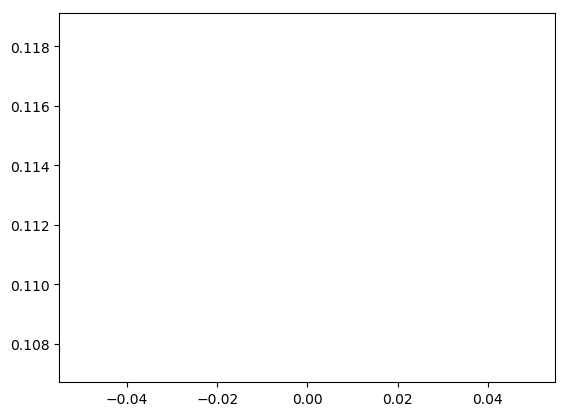

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x132ab48d0>

In [57]:
using PyPlot
plot(norm(currenttrial.Valuemap[find(x->!isnan(x),currenttrial.Valuemap[:])]))